## The goal of this notebook is to select the most relevant features to predict zhvi (and/or change in) and zri (and/or change in)

In [192]:
from fetch_other_data import get_fed_fund, get_mtg_rate, get_market, get_census, get_irs
from fetch_zillow_data import get_zri, get_zhvi

import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.special import boxcox1p, boxcox
from scipy.stats import norm, skew
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
#grab zhvi data
zhvi = get_zhvi(update = False)

In [311]:
#grab data from other sources
mortgage_rate, mortgage_rate_annual = get_mtg_rate(False)
fed_rate, fed_rate_annual = get_fed_fund(False)
market, market_annual = get_market(False)
census = get_census()
irs_zip_summary, irs_state_summary = get_irs(False)

Updated by: freddiemac
date range: 1971-01-01 00:00:00 to 2018-04-01 00:00:00
Updated by: Quandl
date range: 1954-07-01 00:00:00 to 2018-04-01 00:00:00
Updated by: Yahoo! Finance
date range: 1985-01-29 00:00:00 to 2018-05-04 00:00:00
Updated by: American Community Survey (US Census Bureau)
Updated by: IRS


E:\WinUser\Documents\Python Code\Real Estate Intelligence\For Github\fetch_other_data.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  zip_summary['num R z'] = (zip_summary['num R'] - zip_summary[zip_summary['year'] == max(years)]['num R'].mean()) / zip_summary[zip_summary['year'] == max(years)]['num R'].std()
E:\WinUser\Documents\Python Code\Real Estate Intelligence\For Github\fetch_other_data.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  zip_summary['avg AGI z'] = (zip_summary['avg AGI'] - zip_summary[zip_summary['year'] == m

In [260]:
census.head()

County Name ZIP Code         land      water      pop  housing        lat  \
0      Albany    12046   39752712.0  5389579.0    817.0    347.0  42.509465   
1      Albany    12083  111677736.0  1265231.0   3795.0   1839.0  42.424859   
2      Albany    12085     454725.0        0.0    479.0    203.0  42.703313   
3      Albany    12201          NaN        NaN      NaN      NaN        NaN   
4      Albany    12203   29546226.0   163132.0  29952.0  13677.0  42.678763   

        long     2000     2010        ...            2015     2016  \
0 -73.923520    934.0    817.0        ...           855.0    966.0   
1 -74.026509   3153.0   3789.0        ...          3594.0   3673.0   
2 -73.963262      NaN    359.0        ...           601.0    520.0   
3        NaN      NaN      NaN        ...             NaN      NaN   
4 -73.845869  25604.0  26464.0        ...         30518.0  30625.0   

   2000_pop_density  2010_pop_density  2011_pop_density  2012_pop_density  \
0         23.495252         20.552057         24.476317         22.413565   
1         28.233022         33.927980         33.507126         32.862414   
2               NaN        789.488152       1044.587388       1081.972621   
3               NaN               NaN               NaN               NaN   
4        866.574296        895.681228        996.438598       1017.998035   

   2013_pop_density  2014_pop_density  2015_pop_density  2016_pop_density  
0         22.816053         19.420059         21.507967         24.300229  
1         33.453400         32.584830         32.181884         32.889277  
2       1150.145692       1114.959591       1321.677937       1143.548298  
3               NaN               NaN               NaN               NaN  
4       1032.449965       1046.698824       1032.889954       1036.511397  

[5 rows x 24 columns]

In [155]:
#30-year mortgage rate offsets
mortgage_rate['30 FRM Rate 1'] = mortgage_rate['30 FRM Rate'].shift(1)
mortgage_rate['30 FRM Rate 6'] = mortgage_rate['30 FRM Rate'].shift(6)
mortgage_rate['30 FRM Rate 12'] = mortgage_rate['30 FRM Rate'].shift(12)
mortgage_rate['30 FRM Rate 24'] = mortgage_rate['30 FRM Rate'].shift(24)

mortgage_rate['30 FRM Rate pct_change'] = mortgage_rate['30 FRM Rate'].pct_change()
mortgage_rate['30 FRM Rate pct_change 1'] = mortgage_rate['30 FRM Rate pct_change'].shift(1)
mortgage_rate['30 FRM Rate pct_change 6'] = mortgage_rate['30 FRM Rate pct_change'].shift(6)
mortgage_rate['30 FRM Rate pct_change 12'] = mortgage_rate['30 FRM Rate pct_change'].shift(12)
mortgage_rate['30 FRM Rate pct_change 24'] = mortgage_rate['30 FRM Rate pct_change'].shift(24)

mortgage_rate.head(20)

year  30 FRM Rate  30 FRM Pts  15 FRM Rate  15 FRM Pts  \
Date                                                                   
1971-01-01  1971.0          NaN         NaN          NaN         NaN   
1971-02-01  1971.0          NaN         NaN          NaN         NaN   
1971-03-01  1971.0          NaN         NaN          NaN         NaN   
1971-04-01  1971.0         7.31         NaN          NaN         NaN   
1971-05-01  1971.0         7.43         NaN          NaN         NaN   
1971-06-01  1971.0         7.53         NaN          NaN         NaN   
1971-07-01  1971.0         7.60         NaN          NaN         NaN   
1971-08-01  1971.0         7.70         NaN          NaN         NaN   
1971-09-01  1971.0         7.69         NaN          NaN         NaN   
1971-10-01  1971.0         7.63         NaN          NaN         NaN   
1971-11-01  1971.0         7.55         NaN          NaN         NaN   
1971-12-01  1971.0         7.48         NaN          NaN         NaN   
1972-01-01  1972.0         7.44         1.0          NaN         NaN   
1972-02-01  1972.0         7.32         0.9          NaN         NaN   
1972-03-01  1972.0         7.29         0.9          NaN         NaN   
1972-04-01  1972.0         7.29         0.9          NaN         NaN   
1972-05-01  1972.0         7.37         0.9          NaN         NaN   
1972-06-01  1972.0         7.37         0.9          NaN         NaN   
1972-07-01  1972.0         7.40         0.9          NaN         NaN   
1972-08-01  1972.0         7.40         0.9          NaN         NaN   

            5-1 ARM Rate  5-1 ARM Margin  30 FRM Rate 1  30 FRM Rate 6  \
Date                                                                     
1971-01-01           NaN             NaN            NaN            NaN   
1971-02-01           NaN             NaN            NaN            NaN   
1971-03-01           NaN             NaN            NaN            NaN   
1971-04-01           NaN             NaN            NaN            NaN   
1971-05-01           NaN             NaN           7.31            NaN   
1971-06-01           NaN             NaN           7.43            NaN   
1971-07-01           NaN             NaN           7.53            NaN   
1971-08-01           NaN             NaN           7.60            NaN   
1971-09-01           NaN             NaN           7.70            NaN   
1971-10-01           NaN             NaN           7.69           7.31   
1971-11-01           NaN             NaN           7.63           7.43   
1971-12-01           NaN             NaN           7.55           7.53   
1972-01-01           NaN             NaN           7.48           7.60   
1972-02-01           NaN             NaN           7.44           7.70   
1972-03-01           NaN             NaN           7.32           7.69   
1972-04-01           NaN             NaN           7.29           7.63   
1972-05-01           NaN             NaN           7.29           7.55   
1972-06-01           NaN             NaN           7.37           7.48   
1972-07-01           NaN             NaN           7.37           7.44   
1972-08-01           NaN             NaN           7.40           7.32   

            30 FRM Rate 12  30 FRM Rate 24  30 FRM Rate pct_change  \
Date                                                                 
1971-01-01             NaN             NaN                     NaN   
1971-02-01             NaN             NaN                     NaN   
1971-03-01             NaN             NaN                     NaN   
1971-04-01             NaN             NaN                     NaN   
1971-05-01             NaN             NaN                0.016416   
1971-06-01             NaN             NaN                0.013459   
1971-07-01             NaN             NaN                0.009296   
1971-08-01             NaN             NaN                0.013158   
1971-09-01             NaN             NaN               -0.001299   
1971-10-01             NaN    

In [156]:
#fed rate offsets
fed_rate['Fed Rate 1'] = fed_rate['Fed Rate'].shift(1)
fed_rate['Fed Rate 6'] = fed_rate['Fed Rate'].shift(6)
fed_rate['Fed Rate 12'] = fed_rate['Fed Rate'].shift(12)
fed_rate['Fed Rate 24'] = fed_rate['Fed Rate'].shift(24)

fed_rate['Fed Rate pct_change'] = fed_rate['Fed Rate'].pct_change()
fed_rate['Fed Rate pct_change 1'] = fed_rate['Fed Rate pct_change'].shift(1)
fed_rate['Fed Rate pct_change 6'] = fed_rate['Fed Rate pct_change'].shift(6)
fed_rate['Fed Rate pct_change 12'] = fed_rate['Fed Rate pct_change'].shift(12)
fed_rate['Fed Rate pct_change 24'] = fed_rate['Fed Rate pct_change'].shift(24)

fed_rate.head(20)

Fed Rate  year  Fed Rate 1  Fed Rate 6  Fed Rate 12  Fed Rate 24  \
1954-07-01      0.80  1954         NaN         NaN          NaN          NaN   
1954-08-01      1.22  1954        0.80         NaN          NaN          NaN   
1954-09-01      1.06  1954        1.22         NaN          NaN          NaN   
1954-10-01      0.85  1954        1.06         NaN          NaN          NaN   
1954-11-01      0.83  1954        0.85         NaN          NaN          NaN   
1954-12-01      1.28  1954        0.83         NaN          NaN          NaN   
1955-01-01      1.39  1955        1.28        0.80          NaN          NaN   
1955-02-01      1.29  1955        1.39        1.22          NaN          NaN   
1955-03-01      1.35  1955        1.29        1.06          NaN          NaN   
1955-04-01      1.43  1955        1.35        0.85          NaN          NaN   
1955-05-01      1.43  1955        1.43        0.83          NaN          NaN   
1955-06-01      1.64  1955        1.43        1.28          NaN          NaN   
1955-07-01      1.68  1955        1.64        1.39         0.80          NaN   
1955-08-01      1.96  1955        1.68        1.29         1.22          NaN   
1955-09-01      2.18  1955        1.96        1.35         1.06          NaN   
1955-10-01      2.24  1955        2.18        1.43         0.85          NaN   
1955-11-01      2.35  1955        2.24        1.43         0.83          NaN   
1955-12-01      2.48  1955        2.35        1.64         1.28          NaN   
1956-01-01      2.45  1956        2.48        1.68         1.39          NaN   
1956-02-01      2.50  1956        2.45        1.96         1.29          NaN   

            Fed Rate pct_change  Fed Rate pct_change 1  Fed Rate pct_change 6  \
1954-07-01                  NaN                    NaN                    NaN   
1954-08-01             0.525000                    NaN                    NaN   
1954-09-01            -0.131148               0.525000                    NaN   
1954-10-01            -0.198113              -0.131148                    NaN   
1954-11-01            -0.023529              -0.198113                    NaN   
1954-12-01             0.542169              -0.023529                    NaN   
1955-01-01             0.085938               0.542169                    NaN   
1955-02-01            -0.071942               0.085938               0.525000   
1955-03-01             0.046512              -0.071942              -0.131148   
1955-04-01             0.059259               0.046512              -0.198113   
1955-05-01             0.000000               0.059259              -0.023529   
1955-06-01             0.146853               0.000000               0.542169   
1955-07-01             0.024390               0.146853               0.085938   
1955-08-01             0.166667               0.024390              -0.071942   
1955-09-01             0.112245               0.166667               0.046512   
1955-10-01             0.027523               0.112245               0.059259   
1955-11-01             0.049107               0.027523               0.000000   
1955-12-01             0.055319               0.049107               0.146853   
1956-01-01            -0.012097               0.055319               0.024390   
1956-02-01             0.020408              -0.012097               0.166667   

            Fed Rate pct_change 12  Fed Rate pct_change 24  
1954-07-01                     NaN                     NaN  
1954-08-01                     NaN                     NaN  
1954-09-01                     NaN                     NaN  
1954-10-01                     NaN                     NaN  
1954-11-01                     NaN                     NaN  
1954-12-01                     NaN                     NaN  
1955-01-01                     NaN                     NaN  
1955-02-01                     NaN                     NaN  
1955-03-01                     NaN                     NaN  
1955-04-01         

In [157]:
#market movements
#let's do a MA instead of price at specific point
market_ma = market[['Adj Close_d', 'Volume_d', 'Adj Close_n', 'Volume_n', 'Adj Close_s', 'Volume_s']]
market_ma['d_tot'] = market_ma['Adj Close_d'] * market_ma['Volume_d']
market_ma['n_tot'] = market_ma['Adj Close_n'] * market_ma['Volume_n']
market_ma['s_tot'] = market_ma['Adj Close_s'] * market_ma['Volume_s']
market_ma['month'] = market_ma.index.map(lambda x: datetime.datetime(x.year, x.month, 1))
market_ma_groups = market_ma.groupby('month')['d_tot', 'n_tot', 's_tot', 'Volume_d', 'Volume_n', 'Volume_s'].sum()
market_ma_groups['D_MA'] = market_ma_groups['d_tot'] / market_ma_groups['Volume_d']
market_ma_groups['N_MA'] = market_ma_groups['n_tot'] / market_ma_groups['Volume_n']
market_ma_groups['S_MA'] = market_ma_groups['s_tot'] / market_ma_groups['Volume_s']

#Dow
market_ma_groups['D_MA 1'] = market_ma_groups['D_MA'].shift(1)
market_ma_groups['D_MA 6'] = market_ma_groups['D_MA'].shift(6)
market_ma_groups['D_MA 12'] = market_ma_groups['D_MA'].shift(12)
market_ma_groups['D_MA 24'] = market_ma_groups['D_MA'].shift(24)

market_ma_groups['D_MA pct_change'] = market_ma_groups['D_MA'].pct_change()
market_ma_groups['D_MA pct_change 1'] = market_ma_groups['D_MA pct_change'].shift(1)
market_ma_groups['D_MA pct_change 6'] = market_ma_groups['D_MA pct_change'].shift(6)
market_ma_groups['D_MA pct_change 12'] = market_ma_groups['D_MA pct_change'].shift(12)
market_ma_groups['D_MA pct_change 24'] = market_ma_groups['D_MA pct_change'].shift(24)

#S&P
market_ma_groups['S_MA 1'] = market_ma_groups['S_MA'].shift(1)
market_ma_groups['S_MA 6'] = market_ma_groups['S_MA'].shift(6)
market_ma_groups['S_MA 12'] = market_ma_groups['S_MA'].shift(12)
market_ma_groups['S_MA 24'] = market_ma_groups['S_MA'].shift(24)

market_ma_groups['S_MA pct_change'] = market_ma_groups['S_MA'].pct_change()
market_ma_groups['S_MA pct_change 1'] = market_ma_groups['S_MA pct_change'].shift(1)
market_ma_groups['S_MA pct_change 6'] = market_ma_groups['S_MA pct_change'].shift(6)
market_ma_groups['S_MA pct_change 12'] = market_ma_groups['S_MA pct_change'].shift(12)
market_ma_groups['S_MA pct_change 24'] = market_ma_groups['S_MA pct_change'].shift(24)

#NASDAQ
market_ma_groups['N_MA 1'] = market_ma_groups['N_MA'].shift(1)
market_ma_groups['N_MA 6'] = market_ma_groups['N_MA'].shift(6)
market_ma_groups['N_MA 12'] = market_ma_groups['N_MA'].shift(12)
market_ma_groups['N_MA 24'] = market_ma_groups['N_MA'].shift(24)

market_ma_groups['N_MA pct_change'] = market_ma_groups['N_MA'].pct_change()
market_ma_groups['N_MA pct_change 1'] = market_ma_groups['N_MA pct_change'].shift(1)
market_ma_groups['N_MA pct_change 6'] = market_ma_groups['N_MA pct_change'].shift(6)
market_ma_groups['N_MA pct_change 12'] = market_ma_groups['N_MA pct_change'].shift(12)
market_ma_groups['N_MA pct_change 24'] = market_ma_groups['N_MA pct_change'].shift(24)

market_ma_groups.head(20)

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

d_tot         n_tot         s_tot   Volume_d    Volume_n  \
month                                                                         
1985-01-01  5.729492e+10  8.039903e+10  7.502840e+10   44450000   289310000   
1985-02-01  2.660953e+11  4.978199e+11  3.971857e+11  207300000  1742850000   
1985-03-01  2.553606e+11  4.520318e+11  3.865848e+11  201050000  1611310000   
1985-04-01  2.369671e+11  4.231787e+11  3.580460e+11  187110000  1506450000   
1985-05-01  3.102031e+11  4.816224e+11  4.350886e+11  242250000  1673270000   
1985-06-01  2.698726e+11  4.598848e+11  4.000710e+11  205340000  1582580000   
1985-07-01  3.161662e+11  5.351051e+11  4.745506e+11  235130000  1769440000   
1985-08-01  2.335177e+11  4.881183e+11  3.623449e+11  176010000  1636000000   
1985-09-01  2.594581e+11  3.844200e+11  3.424524e+11  196960000  1334990000   
1985-10-01  3.426054e+11  5.309709e+11  4.738020e+11  253060000  1858340000   
1985-11-01  4.358024e+11  5.605561e+11  4.829226e+11  303580000  1840880000   
1985-12-01  5.493722e+11  7.086695e+11  5.813693e+11  361820000  2212020000   
1986-01-01  4.776014e+11  7.925344e+11  5.995382e+11  311020000  2410850000   
1986-02-01  5.570948e+11  8.190503e+11  6.368362e+11  336860000  2345500000   
1986-03-01  6.262942e+11  9.564662e+11  7.468635e+11  355900000  2595900000   
1986-04-01  7.976640e+11  1.077959e+12  7.712428e+11  441280000  2814600000   
1986-05-01  5.404594e+11  9.379351e+11  6.399826e+11  299610000  2412320000   
1986-06-01  4.946437e+11  1.024302e+12  6.502882e+11  264770000  2569400000   
1986-07-01  6.168955e+11  9.324062e+11  7.276701e+11  341490000  2411040000   
1986-08-01  5.485253e+11  7.896180e+11  6.624104e+11  297880000  2101540000   

              Volume_s         D_MA        N_MA        S_MA       D_MA 1  \
month                                                                      
1985-01-01   418200000  1288.974646  277.899242  179.407940          NaN   
1985-02-01  2194620000  1283.624236  285.635528  180.981521  1288.974646   
1985-03-01  2153090000  1270.134609  280.536825  179.548852  1283.624236   
1985-04-01  1981880000  1266.458685  280.911239  180.659754  1270.134609   
1985-05-01  2350340000  1280.508325  287.833041  185.117313  1266.458685   
1985-06-01  2117000000  1314.271957  290.591808  188.980178  1280.508325   
1985-07-01  2463070000  1344.644183  302.414956  192.666300  1314.271957   
1985-08-01  1923200000  1326.729787  298.360798  188.407282  1344.644183   
1985-09-01  1860160000  1317.313872  287.957227  184.098373  1326.729787   
1985-10-01  2543240000  1353.850500  285.723244  186.298578  1317.313872   
1985-11-01  2445370000  1435.543851  304.504415  197.484456  1353.850500   
1985-12-01  2804380000  1518.357866  320.372099  207.307603  1435.543851   
1986-01-01  2879010000  1535.597204  328.736485  208.244578  1518.357866   
1986-02-01  2899100000  1653.787314  349.200720  219.666879  1535.597204   
1986-03-01  3214600000  1759.747613  368.452633  232.334807  1653.787314   
1986-04-01  3240400000  1807.614228  382.988169  238.008530  1759.747613   
1986-05-01  2680240000  1803.876460  388.810397  238.778106  1807.614228   
1986-06-01  2649600000  1868.201467  398.654085  245.428834  1803.876460   
1986-07-01  3029900000  1806.481892  386.723659  240.163085  1868.201467   
1986-08-01  2701900000  1841.430535  375.733016  245.164647  1806.481892   

                   ...          S_MA pct_change 24      N_MA 1      N_MA 6  \
month              ...                                                       
1985-01-01         ...                         NaN         NaN         NaN   
1985-02-01         ...                         NaN  277.899242         NaN   
1985-03-01         ...                         NaN  285.635528         NaN   
1985-04-01         ...                         NaN  280.536825         NaN   
1985-05-01         ...                         NaN  280.911239         NaN   
1985-06-01         ...                         NaN  287.83304

In [158]:
#find five zip codes that have higher # of data points
example_zips = list(zhvi[zhvi['Home Type'] == 'All Homes'].groupby('zip')['zhvi'].count().sort_values(ascending = False).index)[:5]

In [334]:
# dataframe with specific zip codes and 'Home Type' == 'All Homes'
temp1_df = zhvi[(zhvi['zip'].isin(example_zips)) & (zhvi['Home Type'] == 'All Homes')]
temp1_df_allzips = zhvi[(zhvi['Home Type'] == 'All Homes')]

In [160]:
#possible target is also percentage changes
temp1_df['zhvi pct_change'] = temp1_df.groupby(['Home Type', 'zip']).zhvi.pct_change()

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [161]:
#get the targets and features together
temp2_df = pd.merge(temp1_df, mortgage_rate[['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', 
                                             '30 FRM Rate 12', '30 FRM Rate 24', '30 FRM Rate pct_change', 
                                             '30 FRM Rate pct_change 1', '30 FRM Rate pct_change 6', 
                                             '30 FRM Rate pct_change 12', '30 FRM Rate pct_change 24']],
                    how = 'left', left_index = True, right_index = True)

temp2_df = pd.merge(temp2_df, fed_rate[['Fed Rate', 'Fed Rate 1', 'Fed Rate 6', 'Fed Rate 12',
                                        'Fed Rate 24', 'Fed Rate pct_change', 'Fed Rate pct_change 1',
                                        'Fed Rate pct_change 6', 'Fed Rate pct_change 12', 'Fed Rate pct_change 24']],
                    how = 'left', left_index = True, right_index = True)

temp2_df = pd.merge(temp2_df, market_ma_groups[['D_MA', 'N_MA', 'S_MA',
                                                'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 'D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12', 'D_MA pct_change 24',
                                                'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24', 'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24',
                                                'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24', 'S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']],
                    how = 'left', left_index = True, right_index = True)
print(temp2_df.shape)

(1320, 55)


In [165]:
temp2_df.dropna(inplace = True)
print(temp2_df.shape)
temp2_df[temp2_df.zip == '12077'].head()

(1315, 55)


Home Type    zip      zhvi interp  zhvi pct_change  30 FRM Rate  \
1996-05-01  All Homes  12077  149900.0  False         0.007392        8.070   
1996-06-01  All Homes  12077  150900.0  False         0.006671        8.320   
1996-07-01  All Homes  12077  151400.0  False         0.003313        8.245   
1996-08-01  All Homes  12077  151100.0  False        -0.001982        8.000   
1996-09-01  All Homes  12077  150500.0  False        -0.003971        8.230   

            30 FRM Rate 1  30 FRM Rate 6  30 FRM Rate 12  30 FRM Rate 24  \
1996-05-01          7.925         7.3775           7.960            8.60   
1996-06-01          8.070         7.2000           7.570            8.40   
1996-07-01          8.320         7.0300           7.610            8.61   
1996-08-01          8.245         7.0750           7.860            8.51   
1996-09-01          8.000         7.6240           7.636            8.64   

                   ...          N_MA pct_change 24      S_MA 1      S_MA 6  \
1996-05-01         ...                   -0.005778  646.787492  595.772183   
1996-06-01         ...                   -0.005850  660.732332  614.530733   
1996-07-01         ...                   -0.012811  668.560262  614.519990   
1996-08-01         ...                    0.036110  642.839309  649.654963   
1996-09-01         ...                    0.032995  662.581439  646.641976   

               S_MA 12     S_MA 24  S_MA pct_change  S_MA pct_change 1  \
1996-05-01  523.919786  450.846333         0.021560           0.000225   
1996-06-01  539.583644  454.818829         0.011847           0.021560   
1996-07-01  557.443173  451.570361        -0.038472           0.011847   
1996-08-01  559.131191  464.634669         0.030711          -0.038472   
1996-09-01  579.232614  466.799402         0.020294           0.030711   

            S_MA pct_change 6  S_MA pct_change 12  S_MA pct_change 24  
1996-05-01           0.021975            0.031424            0.008438  
1996-06-01           0.031486            0.029897            0.008811  
1996-07-01          -0.000017            0.033099           -0.007142  
1996-08-01           0.057175            0.003028            0.028931  
1996-09-01          -0.004638            0.035951            0.004659  

[5 rows x 55 columns]

In [182]:
#applying scalers
scaler = MinMaxScaler(feature_range = (0.00001, 1))
temp3_df = pd.DataFrame(scaler.fit_transform(temp2_df[['zhvi', 'zhvi pct_change', '30 FRM Rate',
       '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24',
       '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
       '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
       '30 FRM Rate pct_change 24', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6',
       'Fed Rate 12', 'Fed Rate 24', 'Fed Rate pct_change',
       'Fed Rate pct_change 1', 'Fed Rate pct_change 6',
       'Fed Rate pct_change 12', 'Fed Rate pct_change 24', 'D_MA', 'N_MA',
       'S_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 'D_MA pct_change',
       'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12',
       'D_MA pct_change 24', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24',
       'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6',
       'N_MA pct_change 12', 'N_MA pct_change 24', 'S_MA 1', 'S_MA 6',
       'S_MA 12', 'S_MA 24', 'S_MA pct_change', 'S_MA pct_change 1',
       'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']]), 
                     columns = ['zhvi', 'zhvi pct_change', '30 FRM Rate',
       '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24',
       '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
       '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
       '30 FRM Rate pct_change 24', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6',
       'Fed Rate 12', 'Fed Rate 24', 'Fed Rate pct_change',
       'Fed Rate pct_change 1', 'Fed Rate pct_change 6',
       'Fed Rate pct_change 12', 'Fed Rate pct_change 24', 'D_MA', 'N_MA',
       'S_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24', 'D_MA pct_change',
       'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12',
       'D_MA pct_change 24', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24',
       'N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6',
       'N_MA pct_change 12', 'N_MA pct_change 24', 'S_MA 1', 'S_MA 6',
       'S_MA 12', 'S_MA 24', 'S_MA pct_change', 'S_MA pct_change 1',
       'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24'])

In [183]:
temp3_df.index = temp2_df.index
temp3_df[['Home Type', 'zip', 'interp']] = temp2_df[['Home Type', 'zip', 'interp']]
print(temp2_df.head())
print(temp3_df.head())

            Home Type    zip      zhvi interp  zhvi pct_change  30 FRM Rate  \
1996-05-01  All Homes  12077  149900.0  False         0.007392         8.07   
1996-05-01  All Homes  12110  110500.0  False         0.013761         8.07   
1996-05-01  All Homes  12116   63953.0  False        -0.003785         8.07   
1996-05-01  All Homes  12118   96000.0  False        -0.009288         8.07   
1996-05-01  All Homes  14905   63100.0  False         0.017742         8.07   

            30 FRM Rate 1  30 FRM Rate 6  30 FRM Rate 12  30 FRM Rate 24  \
1996-05-01          7.925         7.3775            7.96             8.6   
1996-05-01          7.925         7.3775            7.96             8.6   
1996-05-01          7.925         7.3775            7.96             8.6   
1996-05-01          7.925         7.3775            7.96             8.6   
1996-05-01          7.925         7.3775            7.96             8.6   

                   ...          N_MA pct_change 24      S_MA 1      

In [184]:
print(temp3_df[(temp3_df['zip'] == '12077') & (temp3_df['Home Type'] == 'All Homes')].tail())

                zhvi  zhvi pct_change  30 FRM Rate  30 FRM Rate 1  \
2017-11-01  0.959950         0.548224     0.110260       0.106392   
2017-12-01  0.992491         0.558682     0.116063       0.110260   
2018-01-01  1.000000         0.471958     0.131537       0.116063   
2018-02-01  0.991239         0.417698     0.189563       0.131537   
2018-03-01  0.988319         0.437052     0.210840       0.189563   

            30 FRM Rate 6  30 FRM Rate 12  30 FRM Rate 24  \
2017-11-01       0.127668        0.081247        0.100864   
2017-12-01       0.106392        0.164418        0.104282   
2018-01-01       0.119931        0.154747        0.089325   
2018-02-01       0.102523        0.158616        0.053001   
2018-03-01       0.088984        0.164418        0.058813   

            30 FRM Rate pct_change  30 FRM Rate pct_change 1  \
2017-11-01                0.485600                  0.551395   
2017-12-01                0.494582                  0.485600   
2018-01-01                

### take a look at the targets and their distributions - doesn't seem like transformations are necessary

14905


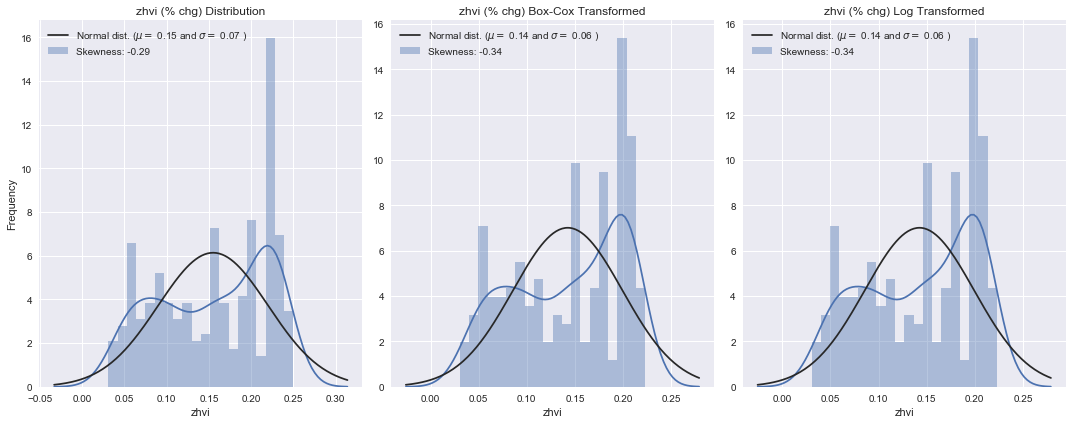

12077


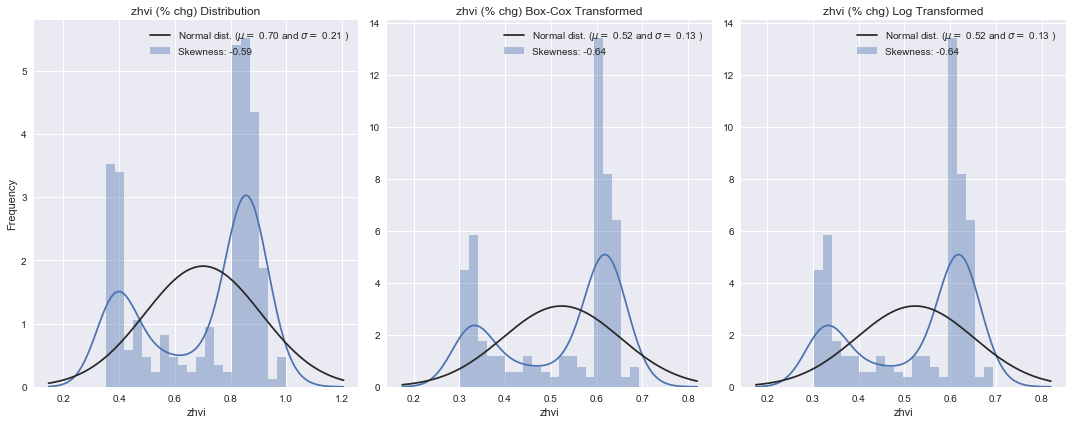

12118


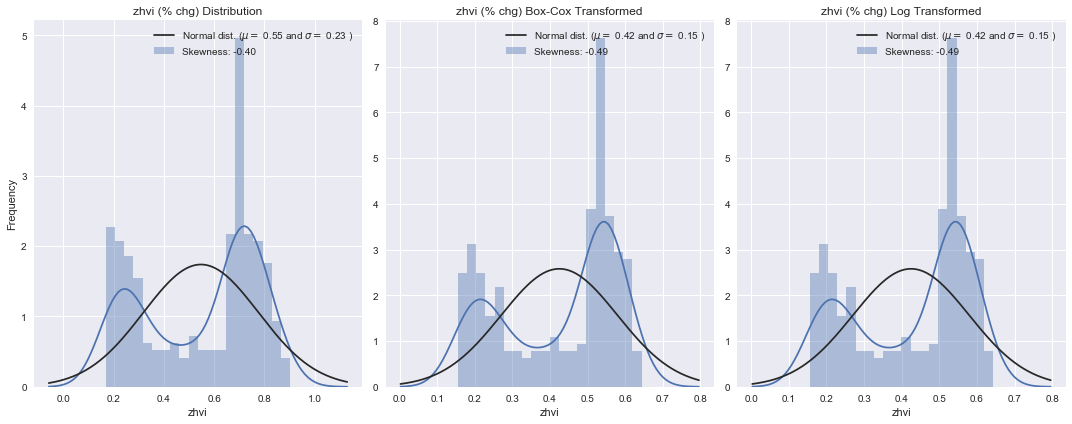

12116


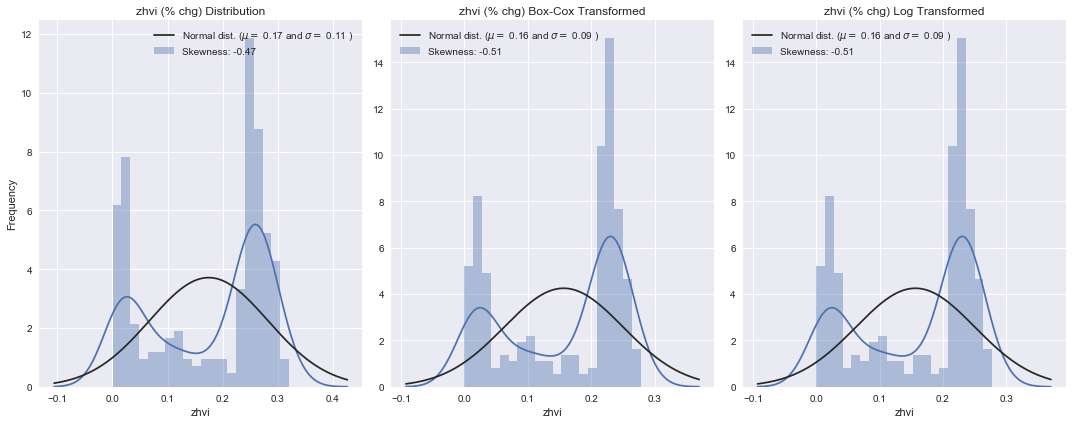

12110


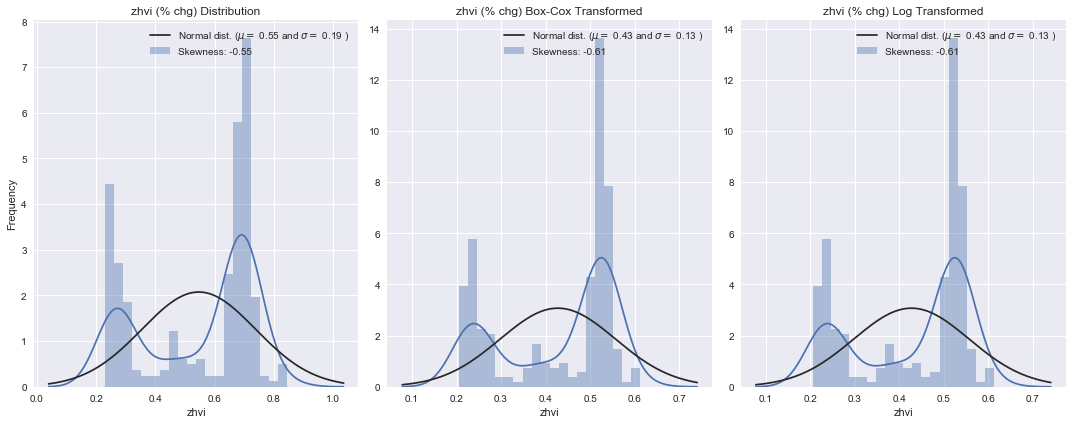

In [221]:
#Target: 'zhvi', trying to correct for skewness
for zipcode in example_zips:
    print(zipcode)
    temp = temp3_df[temp3_df.zip == zipcode]['zhvi'].dropna()
    lam = 0
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
    sns.distplot(temp, fit = norm, ax = ax1, bins = 20)
    sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2, bins = 20)
    sns.distplot(np.log1p(temp), fit = norm, ax = ax3, bins = 20)
    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(temp)
    (mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
    (mu3, sigma3) = norm.fit(np.log1p(temp))
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
                'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
    ax1.set_ylabel('Frequency')
    ax1.set_title('zhvi (% chg) Distribution')
    ax2.set_title('zhvi (% chg) Box-Cox Transformed')
    ax3.set_title('zhvi (% chg) Log Transformed')
    plt.tight_layout()
    plt.show()

14905


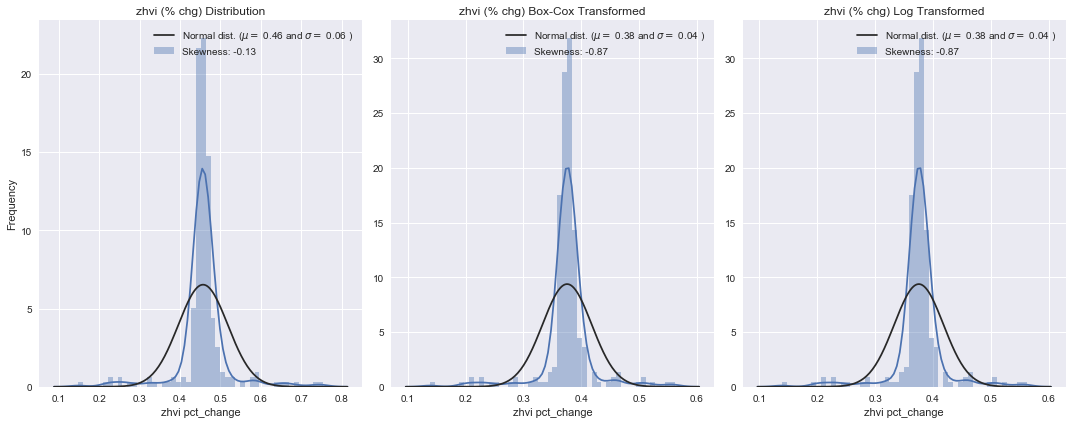

12077


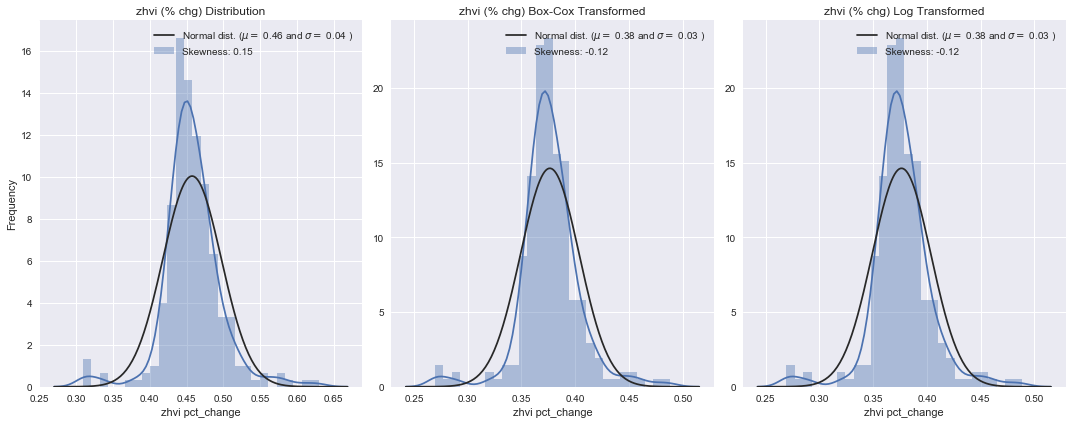

12118


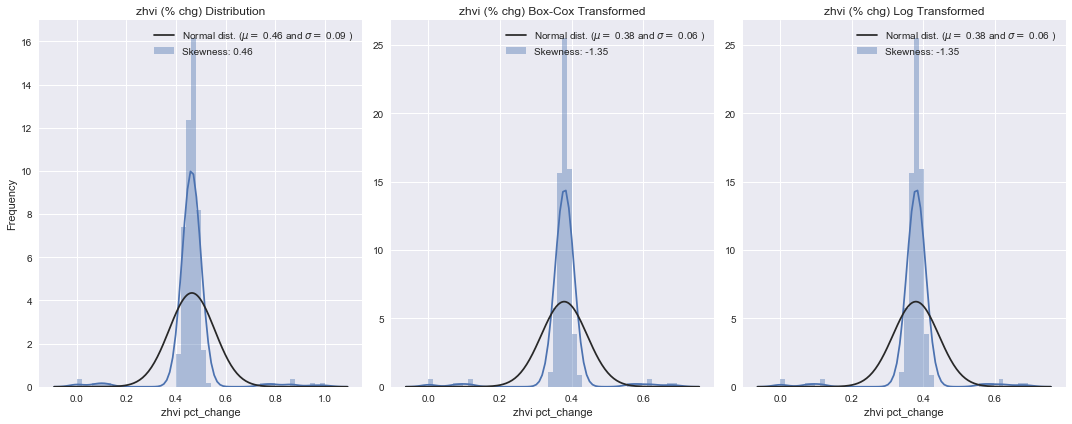

12116


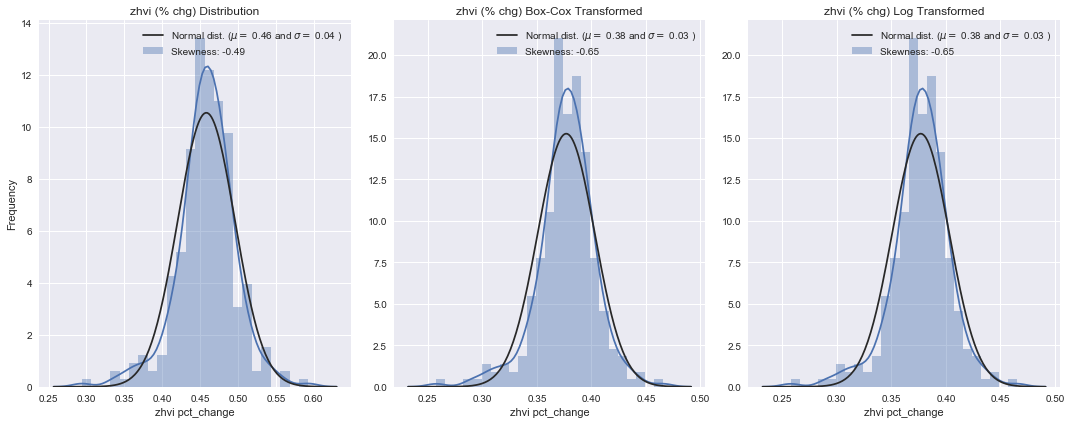

12110


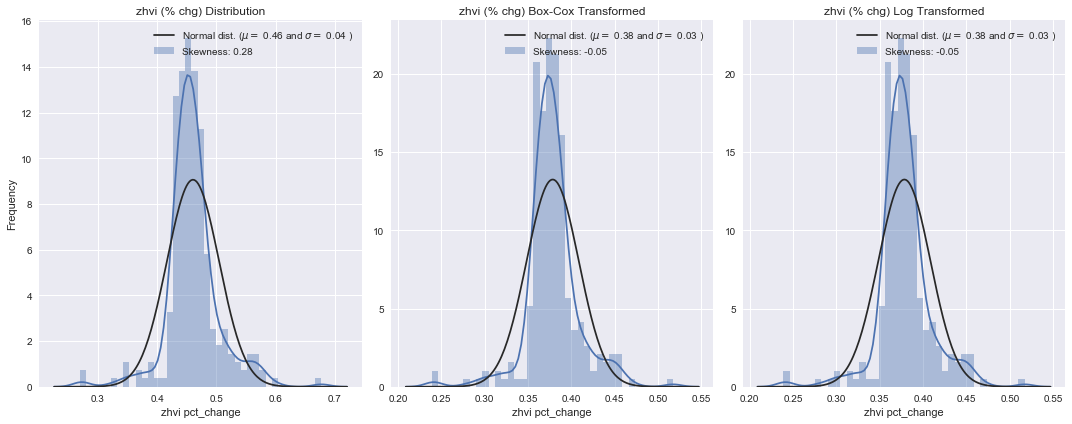

In [222]:
#Target: 'zhvi pct_change', trying to correct for skewness
for zipcode in example_zips:
    print(zipcode)
    temp = temp3_df[temp3_df.zip == zipcode]['zhvi pct_change'].dropna()
    lam = 0
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
    sns.distplot(temp, fit = norm, ax = ax1)
    sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2)
    sns.distplot(np.log1p(temp), fit = norm, ax = ax3)
    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(temp)
    (mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
    (mu3, sigma3) = norm.fit(np.log1p(temp))
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
                'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
    ax1.set_ylabel('Frequency')
    ax1.set_title('zhvi (% chg) Distribution')
    ax2.set_title('zhvi (% chg) Box-Cox Transformed')
    ax3.set_title('zhvi (% chg) Log Transformed')
    plt.tight_layout()
    #plt.savefig('zhvi (% chg) Distribution.png')
    plt.show()

### Doesn't seem like the target(s) need transformation. How about some reatures?

### Mortgage Rates and Change in Mortgage Rates

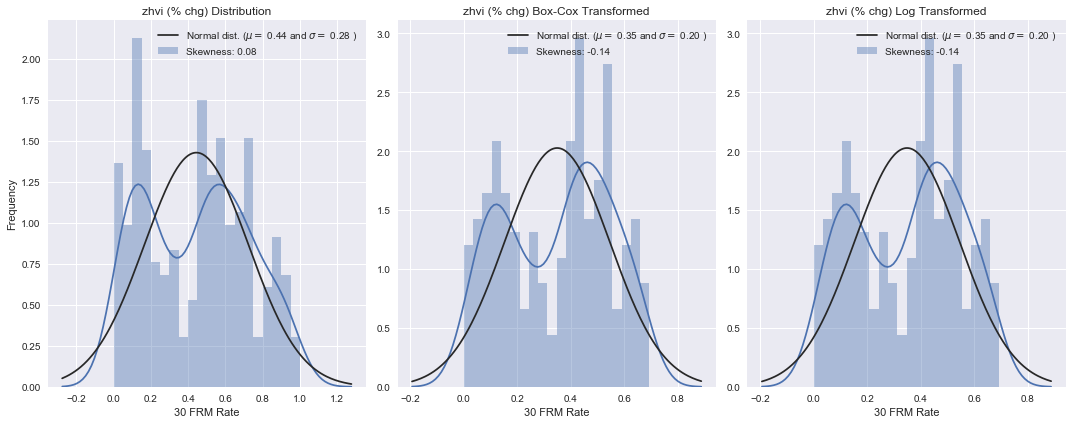

In [223]:
#Feature: '30 FRM Rate', trying to correct for skewness
zipcode = example_zips[0]
temp = temp3_df[temp3_df.zip == zipcode]['30 FRM Rate']
lam = 0
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
sns.distplot(temp, fit = norm, ax = ax1, bins = 20)
sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2, bins = 20)
sns.distplot(np.log1p(temp), fit = norm, ax = ax3, bins = 20)
# Get the fitted parameters used by the function
(mu1, sigma1) = norm.fit(temp)
(mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
(mu3, sigma3) = norm.fit(np.log1p(temp))
ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
            'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
            'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
            'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
ax1.set_ylabel('Frequency')
ax1.set_title('zhvi (% chg) Distribution')
ax2.set_title('zhvi (% chg) Box-Cox Transformed')
ax3.set_title('zhvi (% chg) Log Transformed')
plt.tight_layout()

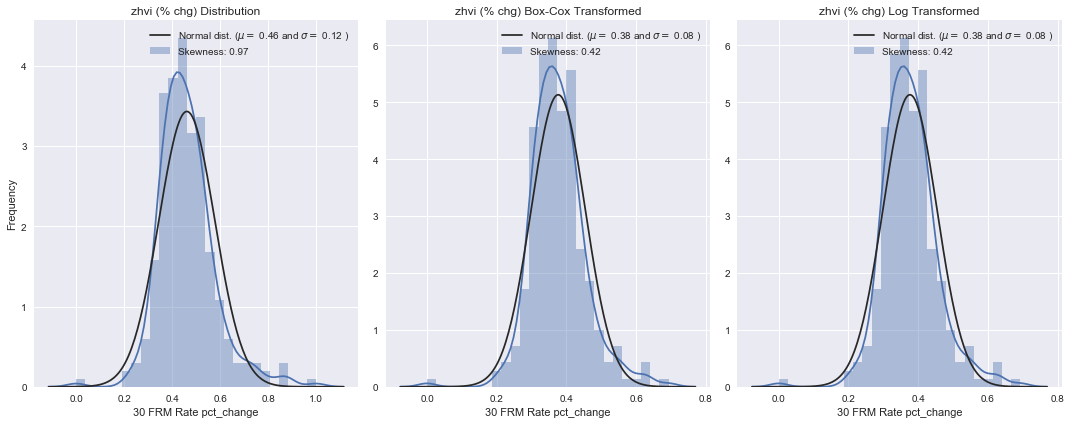

In [224]:
#Feature: '30 FRM Rate pct_change', trying to correct for skewness
zipcode = example_zips[0]
temp = temp3_df[temp3_df.zip == zipcode]['30 FRM Rate pct_change']
lam = 0.0001
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
sns.distplot(temp, fit = norm, ax = ax1)
sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2)
sns.distplot(np.log1p(temp), fit = norm, ax = ax3)
# Get the fitted parameters used by the function
(mu1, sigma1) = norm.fit(temp)
(mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
(mu3, sigma3) = norm.fit(np.log1p(temp))
ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
            'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
            'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
            'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
ax1.set_ylabel('Frequency')
ax1.set_title('zhvi (% chg) Distribution')
ax2.set_title('zhvi (% chg) Box-Cox Transformed')
ax3.set_title('zhvi (% chg) Log Transformed')
plt.tight_layout()

### Fed Rates and Change in Fed Rates

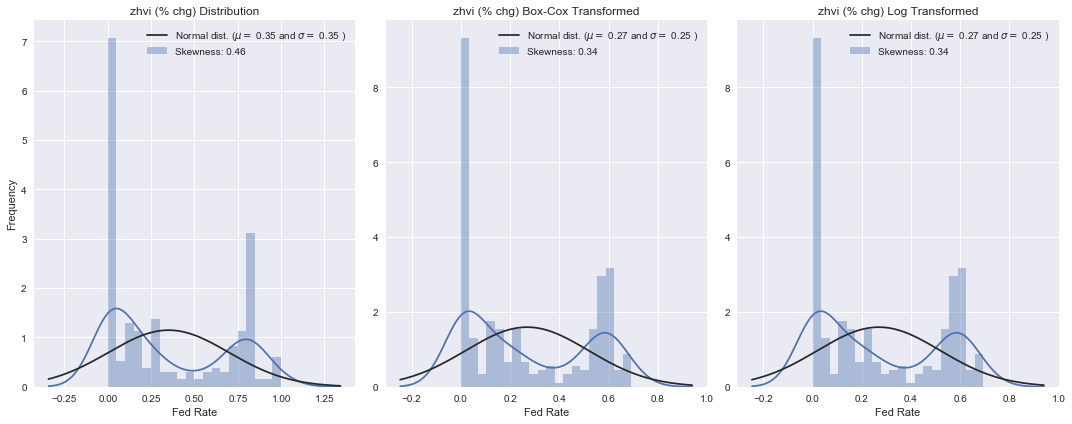

In [225]:
#Feature: 'Fed Rate', trying to correct for skewness
zipcode = example_zips[0]
temp = temp3_df[temp3_df.zip == zipcode]['Fed Rate']
lam = 0
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
sns.distplot(temp, fit = norm, ax = ax1, bins = 20)
sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2, bins = 20)
sns.distplot(np.log1p(temp), fit = norm, ax = ax3, bins = 20)
# Get the fitted parameters used by the function
(mu1, sigma1) = norm.fit(temp)
(mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
(mu3, sigma3) = norm.fit(np.log1p(temp))
ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
            'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
            'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
            'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
ax1.set_ylabel('Frequency')
ax1.set_title('zhvi (% chg) Distribution')
ax2.set_title('zhvi (% chg) Box-Cox Transformed')
ax3.set_title('zhvi (% chg) Log Transformed')
plt.tight_layout()

In [214]:
lam = 0.0001
print('min: {} max: {}'.format(min(temp), max(temp)))
print('boxcox min: {} max: {}'.format(min(boxcox(temp, lam)), max(boxcox(temp, lam))))
print('boxcox1p min: {} max: {}'.format(min(boxcox1p(temp, lam)), max(boxcox1p(temp, lam))))
print('log min: {} max: {}'.format(min(np.log(temp)), max(np.log(temp))))
print('log1p min: {} max: {}'.format(min(np.log(temp)), max(np.log(temp))))

min: 9.999999999999593e-06 max: 1.0000000000000002
boxcox min: -11.506300634948547 max: 2.2204460492503128e-16
boxcox1p min: 9.999950005332873e-06 max: 0.6931712037656919
log min: -11.51292546497027 max: 2.2204460492503128e-16
log1p min: -11.51292546497027 max: 2.2204460492503128e-16


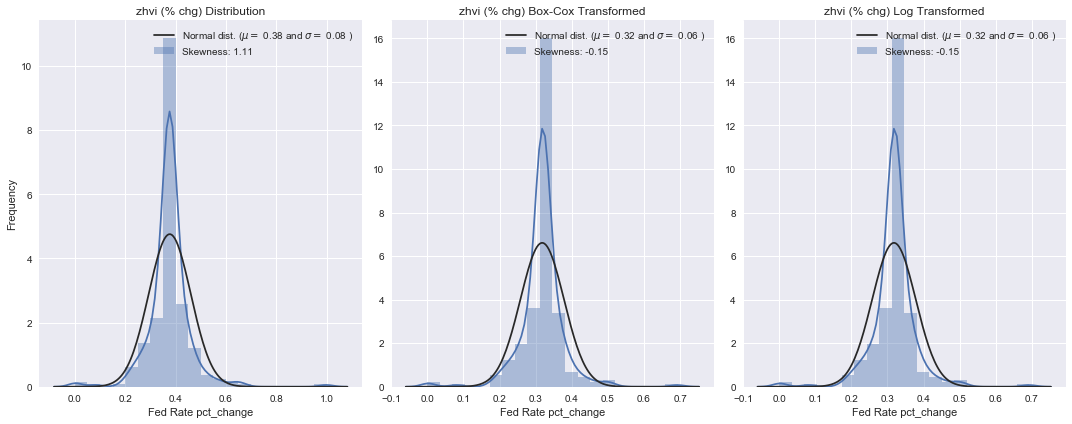

In [226]:
#Feature: 'Fed Rate pct_change', trying to correct for skewness
zipcode = example_zips[0]
temp = temp3_df[temp3_df.zip == zipcode]['Fed Rate pct_change'].dropna()
lam = 0
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
sns.distplot(temp, fit = norm, ax = ax1, bins = 20)
sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2, bins = 20)
sns.distplot(np.log1p(temp), fit = norm, ax = ax3, bins = 20)
# Get the fitted parameters used by the function
(mu1, sigma1) = norm.fit(temp)
(mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
(mu3, sigma3) = norm.fit(np.log1p(temp))
ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
            'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
            'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
            'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
ax1.set_ylabel('Frequency')
ax1.set_title('zhvi (% chg) Distribution')
ax2.set_title('zhvi (% chg) Box-Cox Transformed')
ax3.set_title('zhvi (% chg) Log Transformed')
plt.tight_layout()

### Market Movements and Change in Market Movements

D_MA


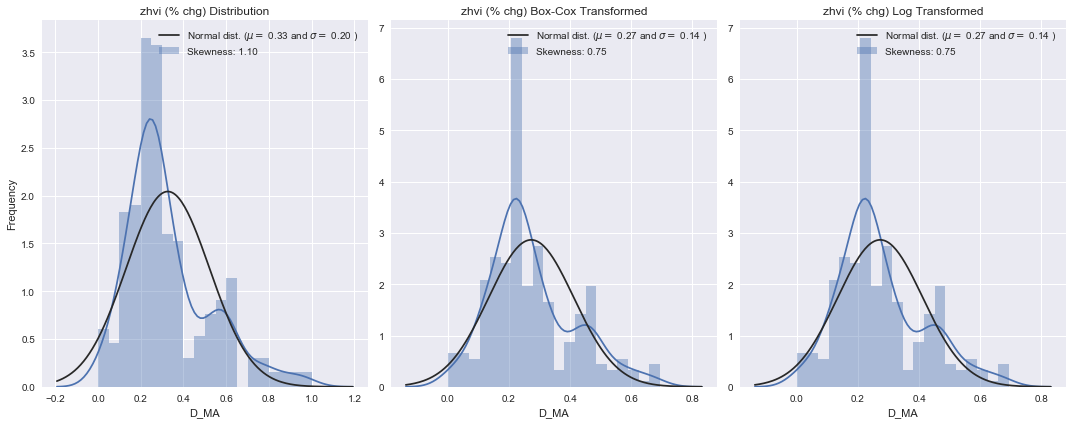

N_MA


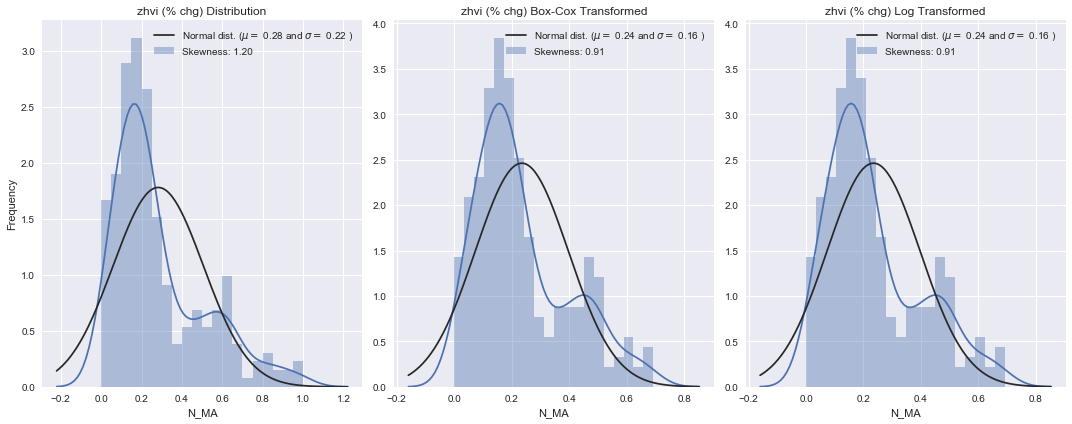

S_MA


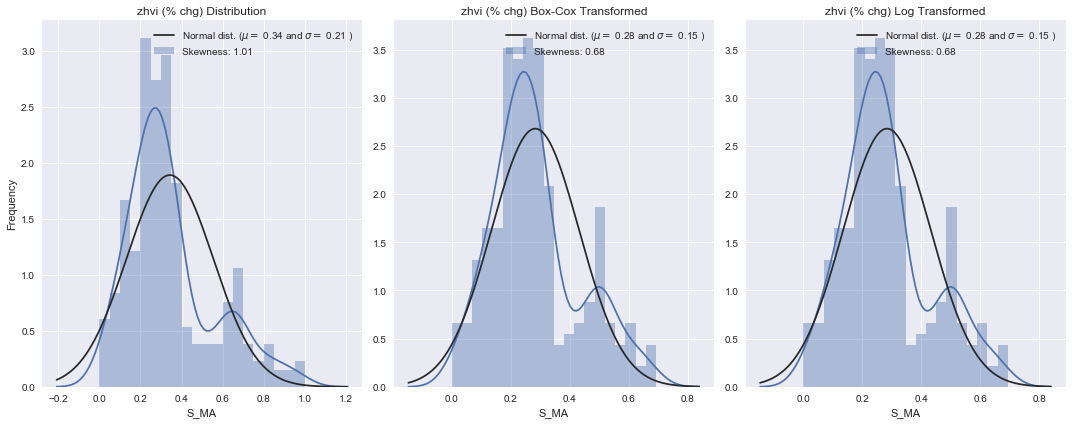

In [227]:
#Feature: 'Fed Rate pct_change', trying to correct for skewness
zipcode = example_zips[0]
for col in ['D_MA', 'N_MA', 'S_MA']:
    print(col)
    temp = temp3_df[temp3_df.zip == zipcode][col]
    lam = 0
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
    sns.distplot(temp, fit = norm, ax = ax1, bins = 20)
    sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2, bins = 20)
    sns.distplot(np.log1p(temp), fit = norm, ax = ax3, bins = 20)
    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(temp)
    (mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
    (mu3, sigma3) = norm.fit(np.log1p(temp))
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
                'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
    ax1.set_ylabel('Frequency')
    ax1.set_title('zhvi (% chg) Distribution')
    ax2.set_title('zhvi (% chg) Box-Cox Transformed')
    ax3.set_title('zhvi (% chg) Log Transformed')
    plt.tight_layout()
    plt.show()

D_MA pct_change


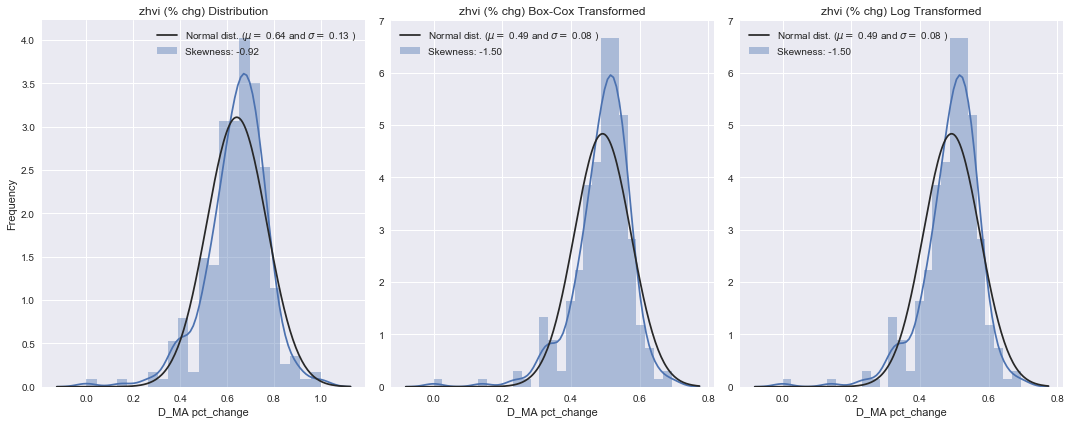

N_MA pct_change


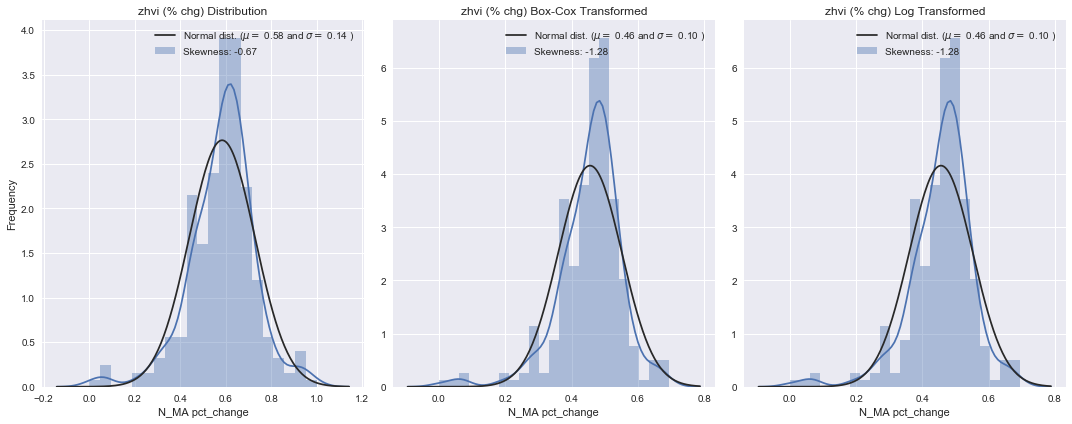

S_MA pct_change


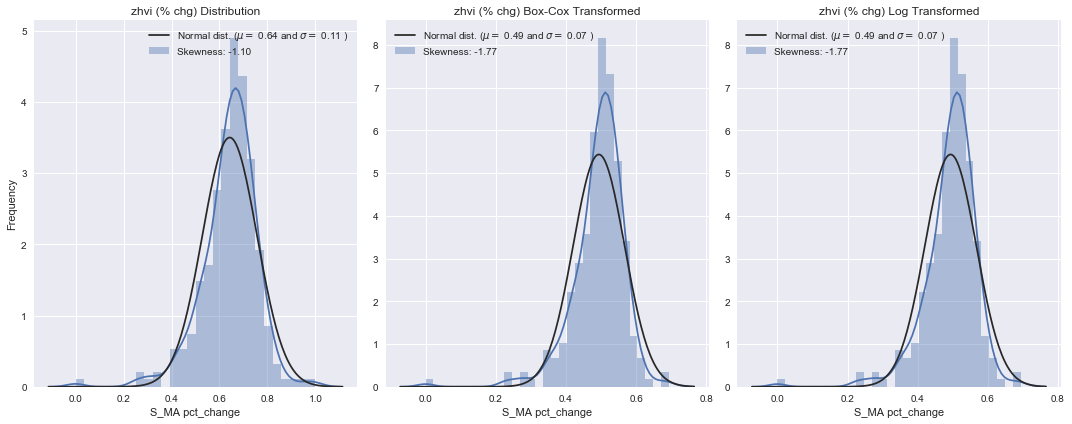

In [228]:
#Feature: '30 FRM Rate pct_change', trying to correct for skewness
for col in ['D_MA pct_change', 'N_MA pct_change', 'S_MA pct_change']:
    print(col)
    zipcode = example_zips[0]
    temp = temp3_df[temp3_df.zip == zipcode][col]
    lam = 0
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
    sns.distplot(temp, fit = norm, ax = ax1)
    sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2)
    sns.distplot(np.log1p(temp), fit = norm, ax = ax3)
    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(temp)
    (mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
    (mu3, sigma3) = norm.fit(np.log1p(temp))
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
                'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
    ax1.set_ylabel('Frequency')
    ax1.set_title('zhvi (% chg) Distribution')
    ax2.set_title('zhvi (% chg) Box-Cox Transformed')
    ax3.set_title('zhvi (% chg) Log Transformed')
    plt.tight_layout()
    plt.show()

### Take a look if the features have any linear relationship with the target

### Mortgage Rates and Change in Mortgage Rates

14905
30 FRM Rate v. zhvi:  (-0.9251915634624747, 7.963347681133759e-112)
30 FRM Rate 1 v. zhvi:  (-0.9253084842580431, 6.543857454733275e-112)
30 FRM Rate 6 v. zhvi:  (-0.916275921210591, 1.0558722925078654e-105)
30 FRM Rate 12 v. zhvi:  (-0.9108456569230468, 2.672756891936034e-102)
30 FRM Rate 24 v. zhvi:  (-0.9182619511592597, 5.2575096451360045e-107)
12077
30 FRM Rate v. zhvi:  (-0.7733854574445711, 1.3726828407096103e-53)
30 FRM Rate 1 v. zhvi:  (-0.7751226515792337, 5.701119788651685e-54)
30 FRM Rate 6 v. zhvi:  (-0.7767312427918499, 2.5092215659433663e-54)
30 FRM Rate 12 v. zhvi:  (-0.781605496466912, 2.0004125240023978e-55)
30 FRM Rate 24 v. zhvi:  (-0.790869199120232, 1.3598770170050129e-57)
12118
30 FRM Rate v. zhvi:  (-0.8674141493763617, 4.3373221306161e-81)
30 FRM Rate 1 v. zhvi:  (-0.8690784303603838, 9.3533164481277e-82)
30 FRM Rate 6 v. zhvi:  (-0.8681318248344024, 2.244040941231745e-81)
30 FRM Rate 12 v. zhvi:  (-0.868757546739379, 1.259310490312299e-81)
30 FRM Rate 24

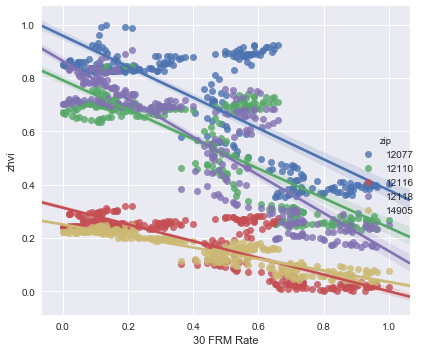

In [229]:
sns.lmplot(data = temp3_df, x = '30 FRM Rate', y = 'zhvi', hue = 'zip')
plt.tight_layout()
for zipcode in example_zips:
    print(zipcode)
    for col in ['30 FRM Rate', '30 FRM Rate 1', '30 FRM Rate 6', '30 FRM Rate 12', '30 FRM Rate 24']:
        print('{} v. zhvi: '.format(col), pearsonr(temp3_df[temp3_df.zip == zipcode]['zhvi'], 
                                                   temp3_df[temp3_df.zip == zipcode][col]))

14905


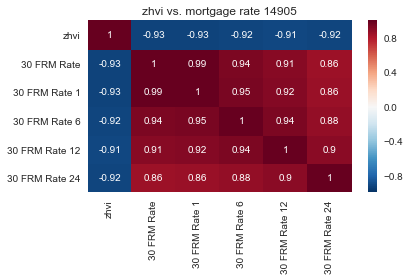

12077


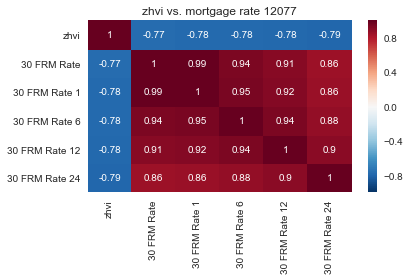

12118


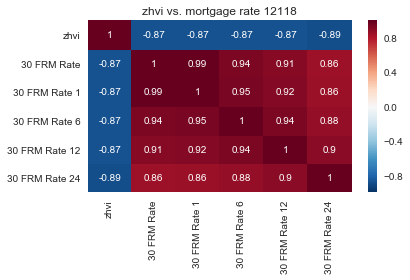

12116


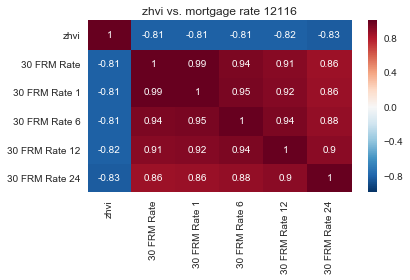

12110


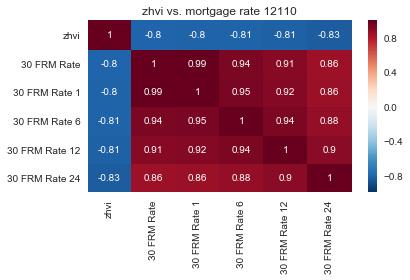

In [231]:
for zipcode in example_zips:
    print(zipcode)
    heatmap1 = temp3_df[temp3_df.zip == zipcode][['zhvi', '30 FRM Rate', '30 FRM Rate 1',
                                                  '30 FRM Rate 6', '30 FRM Rate 12',
                                                  '30 FRM Rate 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. mortgage rate ' + zipcode)
    plt.tight_layout()
    plt.show()

14905
30 FRM Rate pct_change v. zhvi % change:  (-0.008226828452522362, 0.8943646173818521)
30 FRM Rate pct_change 1 v. zhvi % change:  (0.04261410238118866, 0.4913863895101729)
30 FRM Rate pct_change 6 v. zhvi % change:  (-0.07243144352806025, 0.2417661793771669)
30 FRM Rate pct_change 12 v. zhvi % change:  (-0.04757866154960591, 0.44227561921951075)
30 FRM Rate pct_change 24 v. zhvi % change:  (0.011533351928821121, 0.8523233630430602)
12077
30 FRM Rate pct_change v. zhvi % change:  (-0.030889024557228157, 0.6180127854211801)
30 FRM Rate pct_change 1 v. zhvi % change:  (0.05310595415891114, 0.3910377065184234)
30 FRM Rate pct_change 6 v. zhvi % change:  (0.026106901273837878, 0.6734353157151112)
30 FRM Rate pct_change 12 v. zhvi % change:  (0.008719015215940887, 0.8880849676259216)
30 FRM Rate pct_change 24 v. zhvi % change:  (0.10057647167974747, 0.10364449749800655)
12118
30 FRM Rate pct_change v. zhvi % change:  (0.04772173251474587, 0.4409029914480972)
30 FRM Rate pct_change 1 v.

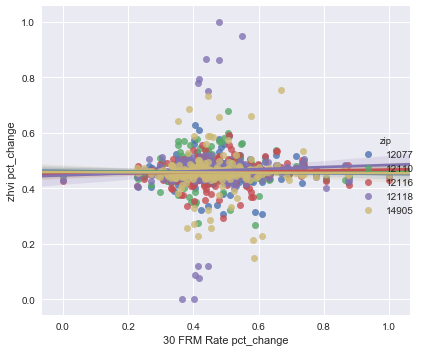

In [233]:
sns.lmplot(data = temp3_df, x = '30 FRM Rate pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['30 FRM Rate pct_change', '30 FRM Rate pct_change 1', '30 FRM Rate pct_change 6', 
                '30 FRM Rate pct_change 12', '30 FRM Rate pct_change 24']:
        temp = temp3_df[temp3_df.zip == zipcode][[col, 'zhvi pct_change']]
        print('{} v. zhvi % change: '.format(col), pearsonr(temp['zhvi pct_change'], temp[col]))

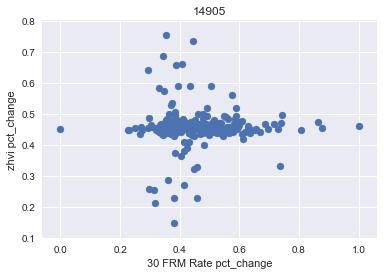

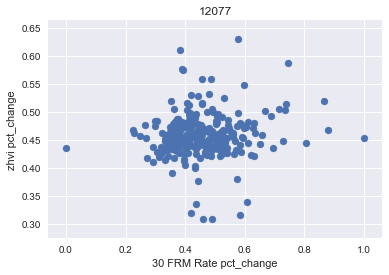

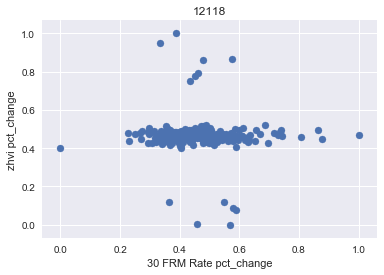

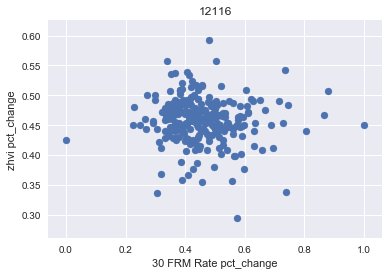

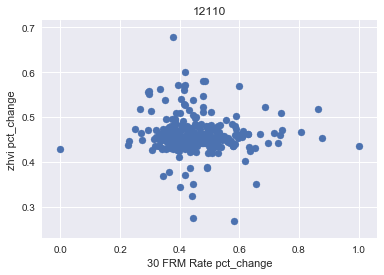

In [234]:
for zipcode in example_zips:
    plt.scatter(x = temp3_df[temp3_df.zip == zipcode]['30 FRM Rate pct_change 24'],
                y = temp3_df[temp3_df.zip == zipcode]['zhvi pct_change'])
    plt.title(zipcode)
    plt.xlabel('30 FRM Rate pct_change')
    plt.ylabel('zhvi pct_change')
    plt.show()

14905


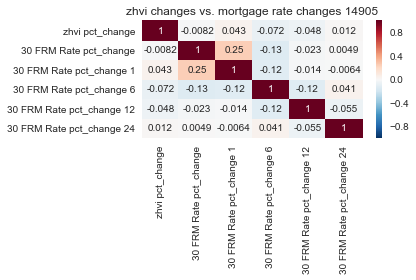

12077


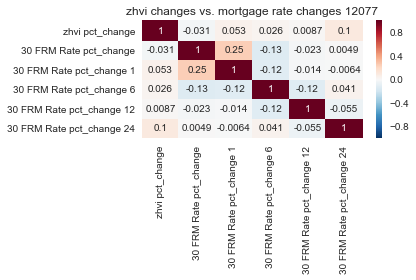

12118


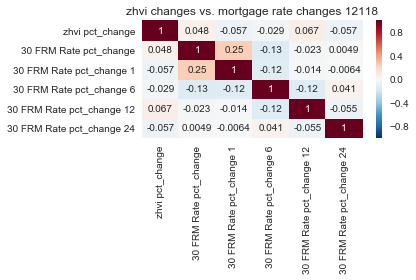

12116


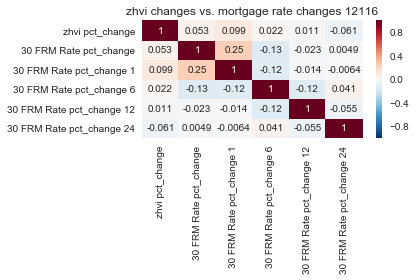

12110


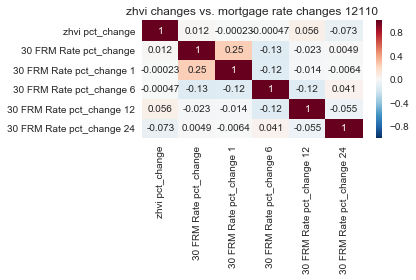

In [236]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi pct_change', '30 FRM Rate pct_change', '30 FRM Rate pct_change 1',
                                                  '30 FRM Rate pct_change 6', '30 FRM Rate pct_change 12',
                                                  '30 FRM Rate pct_change 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi changes vs. mortgage rate changes ' + zipcode)
    plt.tight_layout()
    plt.show()

### Fed Rates and Change in Fed Rates

14905
Fed Rate v. zhvi:  (-0.7786656496992529, 9.26758556352507e-55)
Fed Rate 1 v. zhvi:  (-0.7817822662571247, 1.822861131647376e-55)
Fed Rate 6 v. zhvi:  (-0.797107511078172, 4.0819545143507795e-59)
Fed Rate 12 v. zhvi:  (-0.8177059688445835, 1.5081023602408249e-64)
Fed Rate 24 v. zhvi:  (-0.815671997600751, 5.557870809996277e-64)
12077
Fed Rate v. zhvi:  (-0.6315350002337131, 1.1191562775255933e-30)
Fed Rate 1 v. zhvi:  (-0.635294662670346, 3.940475178205998e-31)
Fed Rate 6 v. zhvi:  (-0.6556811911092627, 1.057272565323538e-33)
Fed Rate 12 v. zhvi:  (-0.686026966201221, 6.386979418637427e-38)
Fed Rate 24 v. zhvi:  (-0.7282306627777764, 9.992322621009692e-45)
12118
Fed Rate v. zhvi:  (-0.7126557002688958, 4.5104431513002824e-42)
Fed Rate 1 v. zhvi:  (-0.7155984253622668, 1.4667002584967097e-42)
Fed Rate 6 v. zhvi:  (-0.7285385173512895, 8.81745418784258e-45)
Fed Rate 12 v. zhvi:  (-0.7488485962582752, 1.5427184469821274e-48)
Fed Rate 24 v. zhvi:  (-0.7767280446023903, 2.5133362467114

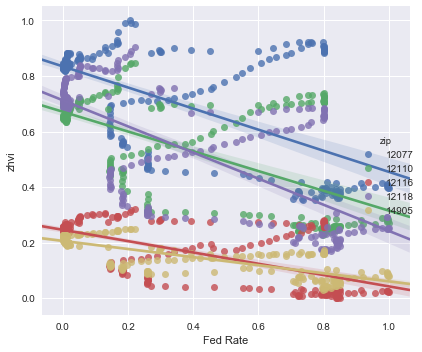

In [237]:
sns.lmplot(data = temp3_df, x = 'Fed Rate', y = 'zhvi', hue = 'zip')
plt.tight_layout()
for zipcode in example_zips:
    print(zipcode)
    for col in ['Fed Rate', 'Fed Rate 1', 'Fed Rate 6', 'Fed Rate 12', 'Fed Rate 24']:
        print('{} v. zhvi: '.format(col), pearsonr(temp3_df[temp3_df.zip == zipcode]['zhvi'], 
                                                   temp3_df[temp3_df.zip == zipcode][col]))

14905


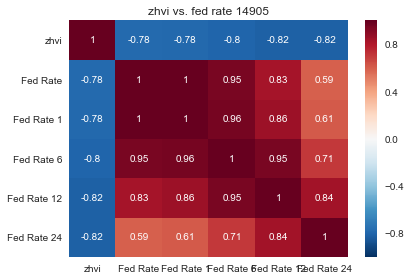

12077


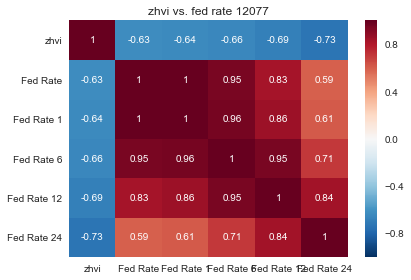

12118


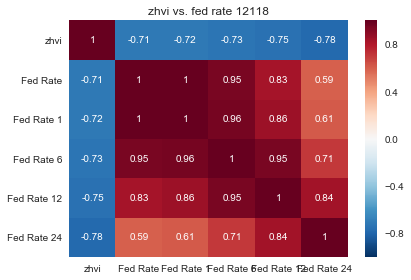

12116


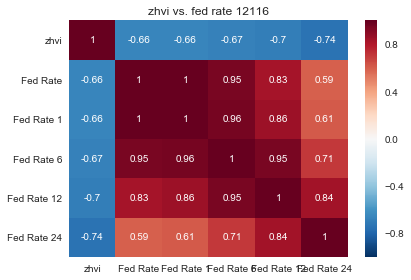

12110


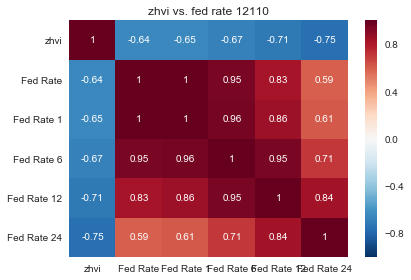

In [238]:
for zipcode in example_zips:
    print(zipcode)
    heatmap1 = temp3_df[temp3_df.zip == zipcode][['zhvi', 'Fed Rate', 'Fed Rate 1', 'Fed Rate 6', 
                                                  'Fed Rate 12', 'Fed Rate 24']].corr()
    sns.heatmap(heatmap1, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. fed rate ' + zipcode)
    plt.tight_layout()
    plt.show()

14905
Fed Rate pct_change v. zhvi % change:  (-0.019759280864395132, 0.7497671000003907)
Fed Rate pct_change 1 v. zhvi % change:  (0.019124146976644774, 0.757555456932875)
Fed Rate pct_change 6 v. zhvi % change:  (-0.015310326064218694, 0.8048125951016998)
Fed Rate pct_change 12 v. zhvi % change:  (-0.0391528176132245, 0.5272757985489644)
Fed Rate pct_change 24 v. zhvi % change:  (0.020196812578466925, 0.7444165123501272)
12077
Fed Rate pct_change v. zhvi % change:  (0.03717457772532165, 0.5483688146010707)
Fed Rate pct_change 1 v. zhvi % change:  (0.03587777636930615, 0.5624172428010603)
Fed Rate pct_change 6 v. zhvi % change:  (0.05522107508063306, 0.37241949093112836)
Fed Rate pct_change 12 v. zhvi % change:  (-0.00418331690410505, 0.94616842181452)
Fed Rate pct_change 24 v. zhvi % change:  (0.0488607495903746, 0.4300621708705431)
12118
Fed Rate pct_change v. zhvi % change:  (0.0072140958585703695, 0.9073060393032198)
Fed Rate pct_change 1 v. zhvi % change:  (0.002246517492257006, 0

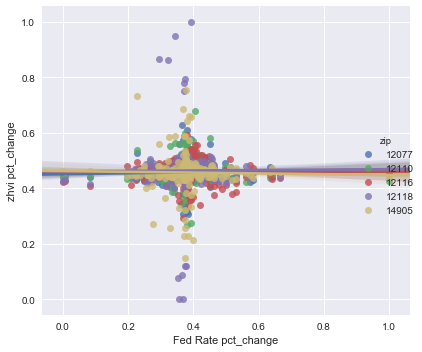

In [239]:
sns.lmplot(data = temp3_df, x = 'Fed Rate pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['Fed Rate pct_change', 'Fed Rate pct_change 1', 'Fed Rate pct_change 6', 
                'Fed Rate pct_change 12', 'Fed Rate pct_change 24']:
        temp = temp3_df[temp3_df.zip == zipcode][[col, 'zhvi pct_change']]
        print('{} v. zhvi % change: '.format(col), pearsonr(temp['zhvi pct_change'], temp[col]))

14905


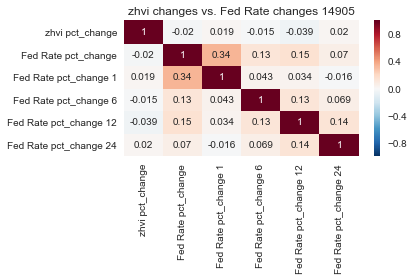

12077


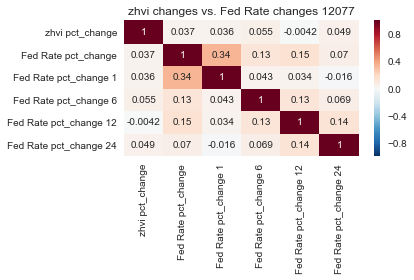

12118


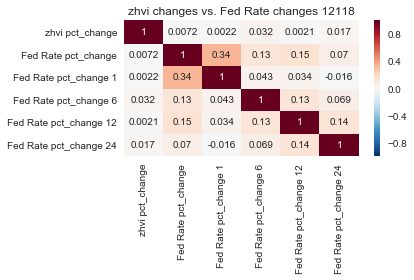

12116


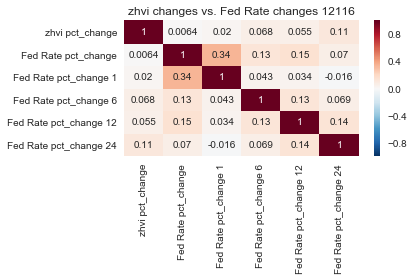

12110


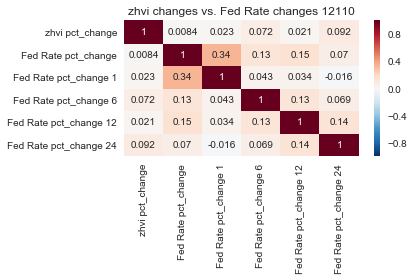

In [240]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi pct_change', 'Fed Rate pct_change', 'Fed Rate pct_change 1',
                                                  'Fed Rate pct_change 6', 'Fed Rate pct_change 12',
                                                  'Fed Rate pct_change 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi changes vs. Fed Rate changes ' + zipcode)
    plt.tight_layout()
    plt.show()

### Market Performance and Change in Market Perf

14905
D_MA v. zhvi:  (0.7646456581247003, 1.0165592231853807e-51)
D_MA 1 v. zhvi:  (0.7665391081909428, 4.064885204750629e-52)
D_MA 6 v. zhvi:  (0.783208904679833, 8.58202459401895e-56)
D_MA 12 v. zhvi:  (0.8001229627800509, 7.171602116457325e-60)
D_MA 24 v. zhvi:  (0.815823609654835, 5.045747709922578e-64)
12077
D_MA v. zhvi:  (0.6116499999642606, 2.2205112671412814e-28)
D_MA 1 v. zhvi:  (0.6152375810079391, 8.789868099921163e-29)
D_MA 6 v. zhvi:  (0.6366044609475042, 2.7298387899761245e-31)
D_MA 12 v. zhvi:  (0.6593775361359236, 3.4392353326123974e-34)
D_MA 24 v. zhvi:  (0.7037313379831057, 1.2501460943673466e-40)
12118
D_MA v. zhvi:  (0.7400353406077114, 7.273503146101564e-47)
D_MA 1 v. zhvi:  (0.7436258137456715, 1.5426745226868787e-47)
D_MA 6 v. zhvi:  (0.7658403910416124, 5.7067219226800424e-52)
D_MA 12 v. zhvi:  (0.7838063959849858, 6.249313945204553e-56)
D_MA 24 v. zhvi:  (0.7997822492767662, 8.741751333016652e-60)
12116
D_MA v. zhvi:  (0.6688042116685581, 1.8232983833691594e-3

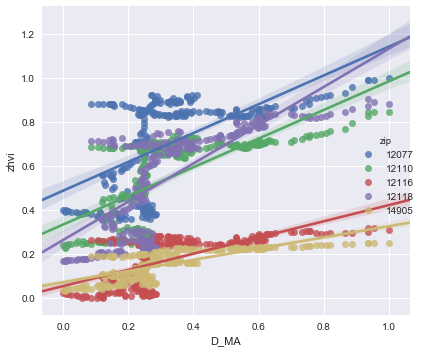

In [250]:
sns.lmplot(data = temp3_df, x = 'D_MA', y = 'zhvi', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['D_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24']:
        temp = temp3_df[temp3_df.zip == zipcode][[col, 'zhvi']]
        print('{} v. zhvi: '.format(col), pearsonr(temp['zhvi'], temp[col]))

14905


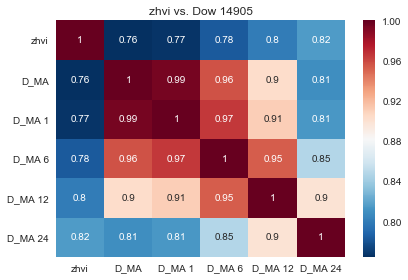

12077


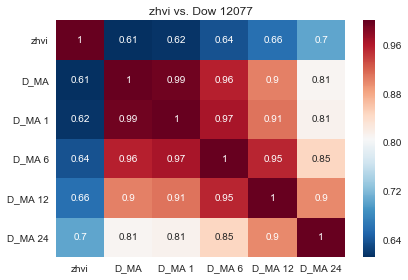

12118


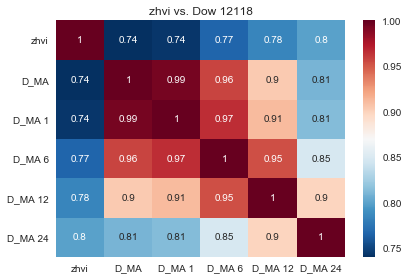

12116


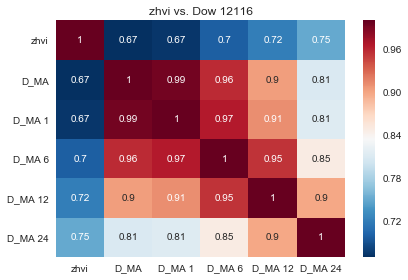

12110


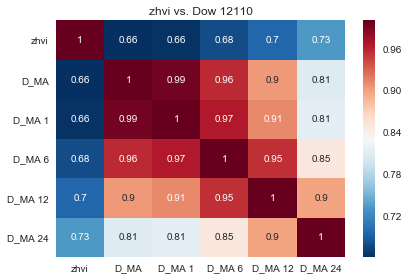

In [244]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi', 'D_MA', 'D_MA 1', 'D_MA 6', 'D_MA 12', 'D_MA 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. Dow ' + zipcode)
    plt.tight_layout()
    plt.show()

14905
S_MA v. zhvi % change:  (0.6804884862367176, 4.105034734081931e-37)
S_MA 1 v. zhvi % change:  (0.6807106569393968, 3.812826161378419e-37)
S_MA 6 v. zhvi % change:  (0.6863201511102159, 5.781222699822494e-38)
S_MA 12 v. zhvi % change:  (0.6958039435570956, 2.1579334600851657e-39)
S_MA 24 v. zhvi % change:  (0.7077765183306292, 2.8167620238572284e-41)
12077
S_MA v. zhvi % change:  (0.5109495132649315, 6.808424944448459e-19)
S_MA 1 v. zhvi % change:  (0.5128776862842681, 4.784539194909858e-19)
S_MA 6 v. zhvi % change:  (0.5244704589333432, 5.469266987236006e-20)
S_MA 12 v. zhvi % change:  (0.542611835372854, 1.5471034151719995e-21)
S_MA 24 v. zhvi % change:  (0.5907055221421188, 3.9532517569487635e-26)
12118
S_MA v. zhvi % change:  (0.6552497230900269, 1.204127063734604e-33)
S_MA 1 v. zhvi % change:  (0.6570139184626056, 7.065252427022483e-34)
S_MA 6 v. zhvi % change:  (0.6669179548722259, 3.3100504598549904e-35)
S_MA 12 v. zhvi % change:  (0.6772084050956172, 1.2120210879950754e-36

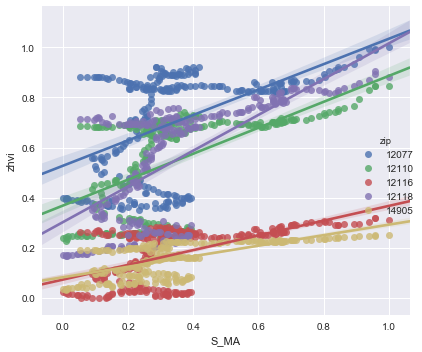

In [242]:
sns.lmplot(data = temp3_df, x = 'S_MA', y = 'zhvi', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24']:
        temp = temp3_df[temp3_df.zip == zipcode][[col, 'zhvi']]
        print('{} v. zhvi: '.format(col), pearsonr(temp['zhvi'], temp[col]))

14905


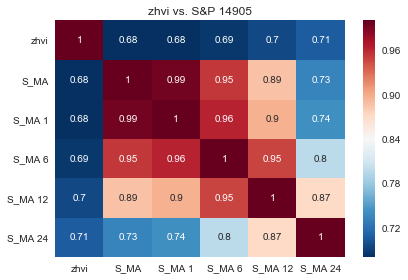

12077


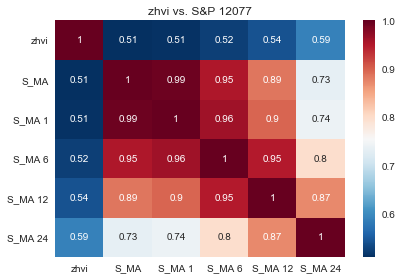

12118


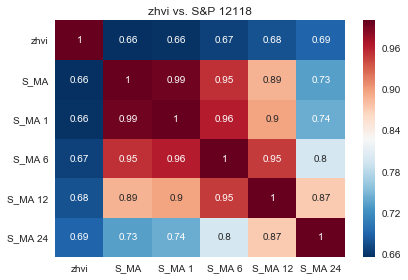

12116


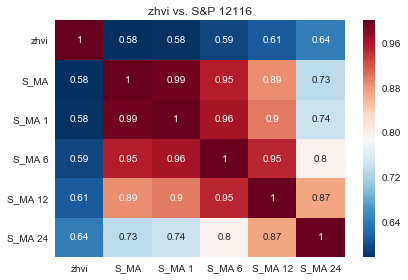

12110


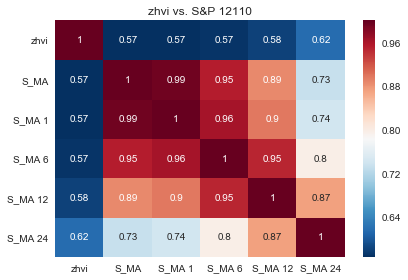

In [246]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi', 'S_MA', 'S_MA 1', 'S_MA 6', 'S_MA 12', 'S_MA 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. S&P ' + zipcode)
    plt.tight_layout()
    plt.show()

14905
N_MA v. zhvi:  (0.6496625887226034, 6.365573361254746e-33)
N_MA 1 v. zhvi:  (0.6500700577256175, 5.6443118028912976e-33)
N_MA 6 v. zhvi:  (0.6544983819864386, 1.5094305130117578e-33)
N_MA 12 v. zhvi:  (0.6569715272710192, 7.156647423825609e-34)
N_MA 24 v. zhvi:  (0.6391921617884995, 1.3149972550266898e-31)
12077
N_MA v. zhvi:  (0.4492181537917831, 1.8207006704981185e-14)
N_MA 1 v. zhvi:  (0.44903201088728134, 1.871901590210655e-14)
N_MA 6 v. zhvi:  (0.44811186153769617, 2.146416498798582e-14)
N_MA 12 v. zhvi:  (0.4507709331026466, 1.4437061836847035e-14)
N_MA 24 v. zhvi:  (0.4801992522150678, 1.4123255395082694e-16)
12118
N_MA v. zhvi:  (0.6089084226136293, 4.472704739064027e-28)
N_MA 1 v. zhvi:  (0.6088389531690056, 4.5523741772749465e-28)
N_MA 6 v. zhvi:  (0.608604768812047, 4.831391717475762e-28)
N_MA 12 v. zhvi:  (0.6057142258226464, 1.0027399177310994e-27)
N_MA 24 v. zhvi:  (0.6007512275587161, 3.452885843115545e-27)
12116
N_MA v. zhvi:  (0.5211657433810893, 1.02356316336833

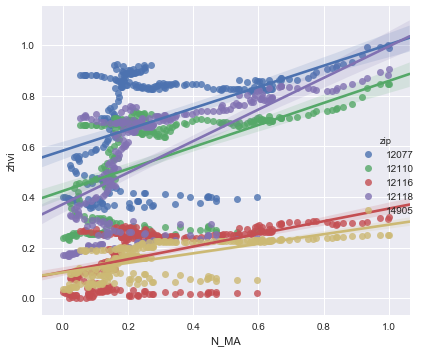

In [248]:
sns.lmplot(data = temp3_df, x = 'N_MA', y = 'zhvi', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24']:
        temp = temp3_df[temp3_df.zip == zipcode][[col, 'zhvi']]
        print('{} v. zhvi: '.format(col), pearsonr(temp['zhvi'], temp[col]))

14905


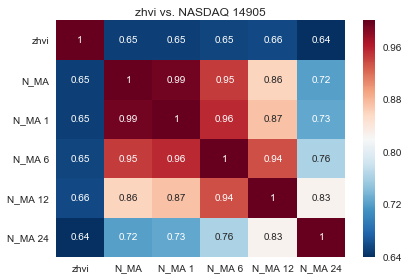

12077


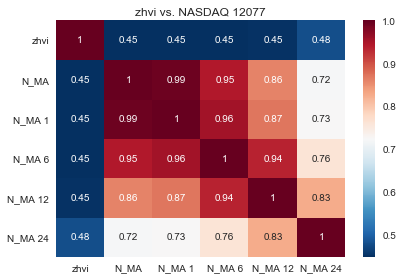

12118


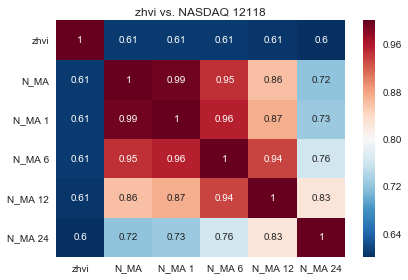

12116


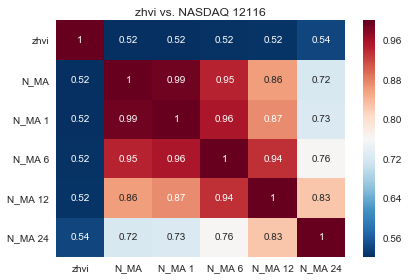

12110


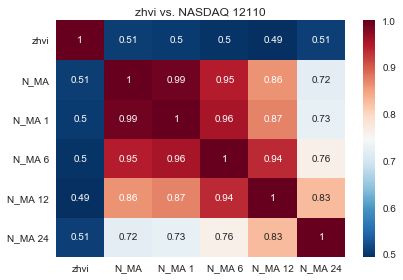

In [249]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi', 'N_MA', 'N_MA 1', 'N_MA 6', 'N_MA 12', 'N_MA 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi vs. NASDAQ ' + zipcode)
    plt.tight_layout()
    plt.show()

14905
D_MA pct_change v. zhvi pct_change:  (0.030001727212172938, 0.628146191216727)
D_MA pct_change 1 v. zhvi pct_change:  (-0.04747159898388467, 0.443304369370054)
D_MA pct_change 6 v. zhvi pct_change:  (-0.08316706526836559, 0.17873851205417038)
D_MA pct_change 12 v. zhvi pct_change:  (0.08765267445250571, 0.1563525395831991)
D_MA pct_change 24 v. zhvi pct_change:  (0.008593780163429782, 0.8896821542632865)
12077
D_MA pct_change v. zhvi pct_change:  (-0.06864501567018964, 0.26732607122926)
D_MA pct_change 1 v. zhvi pct_change:  (0.051752385794015525, 0.4032419960757334)
D_MA pct_change 6 v. zhvi pct_change:  (-0.05247739014650377, 0.39667710340243467)
D_MA pct_change 12 v. zhvi pct_change:  (0.07998319084134346, 0.1960099002183944)
D_MA pct_change 24 v. zhvi pct_change:  (-0.03499106385282758, 0.572121538742085)
12118
D_MA pct_change v. zhvi pct_change:  (0.11047497010315013, 0.07368771714165186)
D_MA pct_change 1 v. zhvi pct_change:  (0.002007245440815575, 0.9741554319451646)
D_MA 

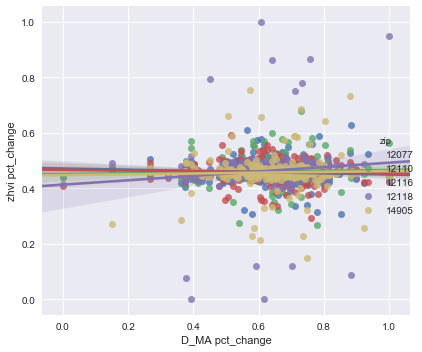

In [251]:
sns.lmplot(data = temp3_df, x = 'D_MA pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 'D_MA pct_change 12', 'D_MA pct_change 24']:
        temp = temp3_df[temp3_df.zip == zipcode][[col, 'zhvi pct_change']]
        print('{} v. zhvi pct_change: '.format(col), pearsonr(temp['zhvi pct_change'], temp[col]))

14905


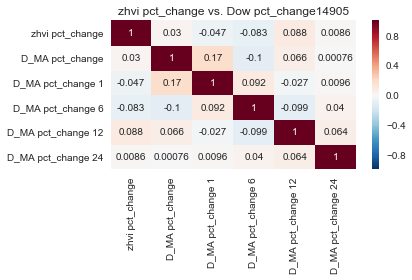

12077


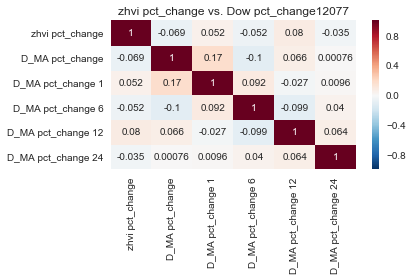

12118


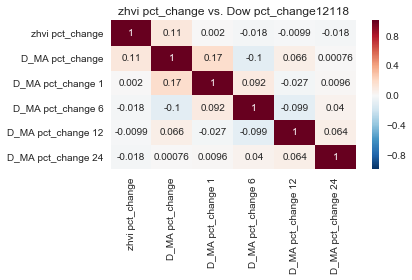

12116


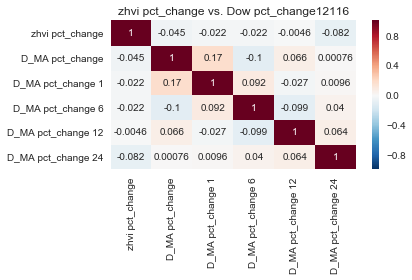

12110


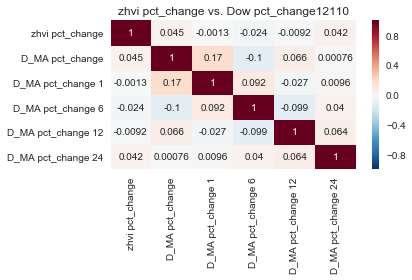

In [252]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi pct_change', 'D_MA pct_change', 'D_MA pct_change 1', 'D_MA pct_change 6', 
                                                  'D_MA pct_change 12', 'D_MA pct_change 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi pct_change vs. Dow pct_change' + zipcode)
    plt.tight_layout()
    plt.show()

14905
S_MA pct_change v. zhvi pct_change:  (0.06159992116488201, 0.3196536817024461)
S_MA pct_change 1 v. zhvi pct_change:  (-0.05982425618669176, 0.3338285548853861)
S_MA pct_change 6 v. zhvi pct_change:  (-0.05882994066668331, 0.3419394118930016)
S_MA pct_change 12 v. zhvi pct_change:  (0.12763480224434146, 0.038593353919655946)
S_MA pct_change 24 v. zhvi pct_change:  (0.01132912864789455, 0.8549091913953268)
12077
S_MA pct_change v. zhvi pct_change:  (-0.05201811889816341, 0.40082831371134087)
S_MA pct_change 1 v. zhvi pct_change:  (0.008621548559150755, 0.8893279710731903)
S_MA pct_change 6 v. zhvi pct_change:  (-0.07644691050259331, 0.2165833988210569)
S_MA pct_change 12 v. zhvi pct_change:  (0.05337395831081099, 0.38864800149294554)
S_MA pct_change 24 v. zhvi pct_change:  (-0.0554906805163528, 0.37008619347834915)
12118
S_MA pct_change v. zhvi pct_change:  (0.10599494514688879, 0.08623575677306138)
S_MA pct_change 1 v. zhvi pct_change:  (0.03030031960364732, 0.6247281951406309)
S

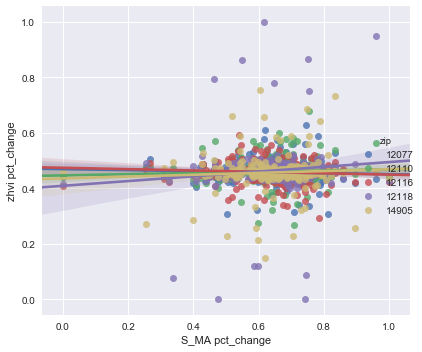

In [253]:
sns.lmplot(data = temp3_df, x = 'S_MA pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['S_MA pct_change', 'S_MA pct_change 1', 'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']:
        temp = temp3_df[temp3_df.zip == zipcode][[col, 'zhvi pct_change']]
        print('{} v. zhvi pct_change: '.format(col), pearsonr(temp['zhvi pct_change'], temp[col]))

14905


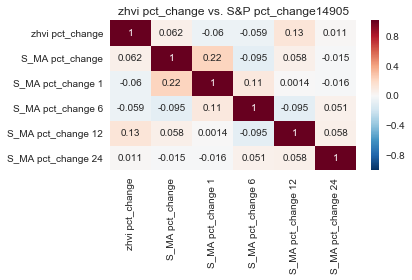

12077


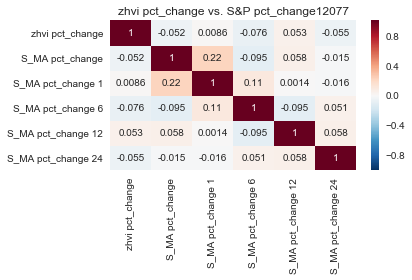

12118


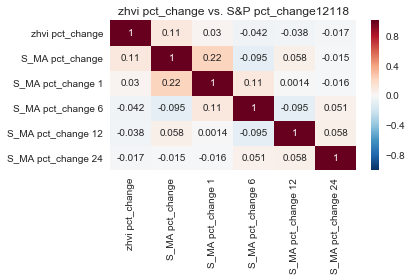

12116


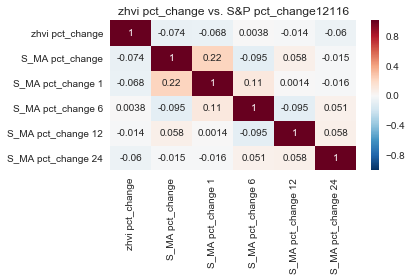

12110


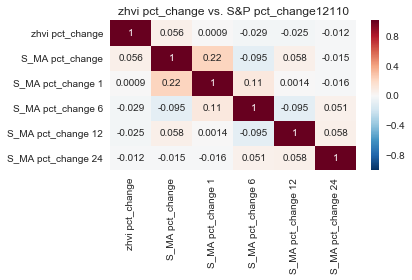

In [254]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi pct_change', 'S_MA pct_change', 'S_MA pct_change 1', 
                                                  'S_MA pct_change 6', 'S_MA pct_change 12', 'S_MA pct_change 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi pct_change vs. S&P pct_change' + zipcode)
    plt.tight_layout()
    plt.show()

14905
N_MA pct_change v. zhvi pct_change:  (0.07433070752408748, 0.22961071022174773)
N_MA pct_change 1 v. zhvi pct_change:  (-0.03679318552993175, 0.5524825464493685)
N_MA pct_change 6 v. zhvi pct_change:  (-0.007515378630864937, 0.9034533176030959)
N_MA pct_change 12 v. zhvi pct_change:  (0.15082062737902674, 0.014354418648306886)
N_MA pct_change 24 v. zhvi pct_change:  (-0.031108114529529444, 0.6155216465918063)
12077
N_MA pct_change v. zhvi pct_change:  (-0.029146403953257523, 0.637980877268248)
N_MA pct_change 1 v. zhvi pct_change:  (0.057996581599535996, 0.34883302760011536)
N_MA pct_change 6 v. zhvi pct_change:  (-0.10457907249771822, 0.09054054834435063)
N_MA pct_change 12 v. zhvi pct_change:  (0.05112432335538944, 0.4089810549327302)
N_MA pct_change 24 v. zhvi pct_change:  (-0.06888875974868845, 0.26562708532219337)
12118
N_MA pct_change v. zhvi pct_change:  (0.07433925658498318, 0.229556990977613)
N_MA pct_change 1 v. zhvi pct_change:  (0.06793110803588982, 0.2723449467118143

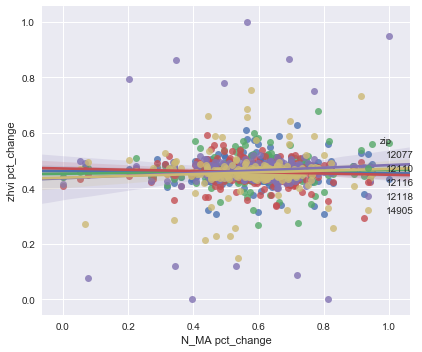

In [255]:
sns.lmplot(data = temp3_df, x = 'N_MA pct_change', y = 'zhvi pct_change', hue = 'zip')
plt.tight_layout()

for zipcode in example_zips:
    print(zipcode)
    for col in ['N_MA pct_change', 'N_MA pct_change 1', 'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24']:
        temp = temp3_df[temp3_df.zip == zipcode][[col, 'zhvi pct_change']]
        print('{} v. zhvi pct_change: '.format(col), pearsonr(temp['zhvi pct_change'], temp[col]))

14905


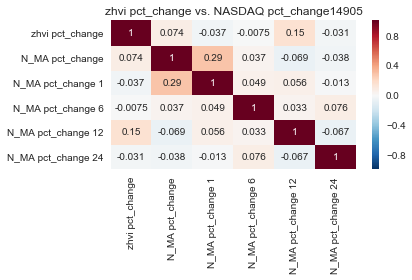

12077


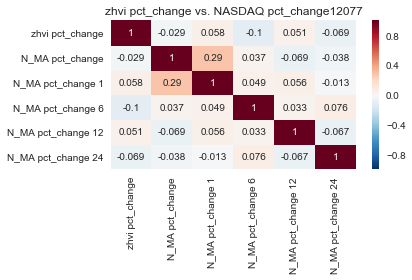

12118


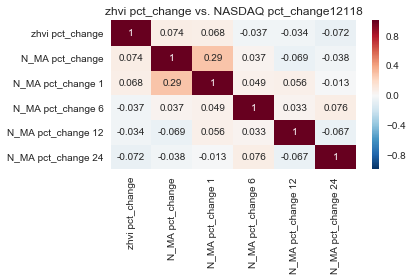

12116


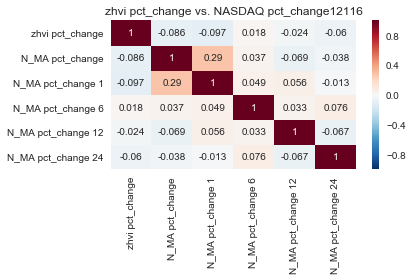

12110


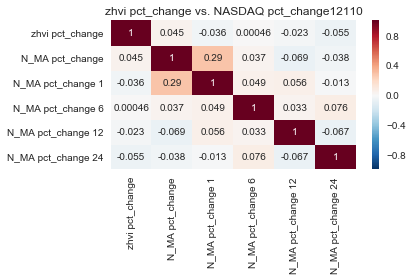

In [256]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi pct_change', 'N_MA pct_change', 'N_MA pct_change 1', 
                                                  'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi pct_change vs. NASDAQ pct_change ' + zipcode)
    plt.tight_layout()
    plt.show()

### Summarize zhvi by year, and merge with yearly data

In [390]:
temp1_df_allzips['year'] = temp1_df_allzips.index.year
temp1_df_annual = temp1_df_allzips[temp1_df_allzips.index.month == 1]
#not sure why pct_change didn't work
temp1_df_annual['zhvi pct_change'] = temp1_df_annual['zhvi'] / temp1_df_annual.groupby(['zip'])['zhvi'].shift(1) - 1
print(temp1_df_annual.shape)
#temp1_df_annual[temp1_df_annual.zip == '12077'].head(25)
temp1_df_annual.head(25)

(18470, 6)


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Home Type    zip      zhvi interp  year  zhvi pct_change
1997-01-01  All Homes  10501  287638.0  False  1997              NaN
1998-01-01  All Homes  10501  321217.0  False  1998         0.116740
1999-01-01  All Homes  10501  345415.0  False  1999         0.075332
2000-01-01  All Homes  10501  382429.0  False  2000         0.107158
2001-01-01  All Homes  10501  454143.0  False  2001         0.187522
2002-01-01  All Homes  10501  510584.0  False  2002         0.124280
2003-01-01  All Homes  10501  552778.0  False  2003         0.082639
2004-01-01  All Homes  10501  601200.0  False  2004         0.087598
2005-01-01  All Homes  10501  656783.0  False  2005         0.092453
2006-01-01  All Homes  10501  708789.0  False  2006         0.079183
2007-01-01  All Homes  10501  692805.0  False  2007        -0.022551
2008-01-01  All Homes  10501  680626.0  False  2008        -0.017579
2009-01-01  All Homes  10501  645100.0  False  2009        -0.052196
2010-01-01  All Homes  10501  579800.0  False  2010        -0.101225
2011-01-01  All Homes  10501  566900.0  False  2011        -0.022249
2012-01-01  All Homes  10501  555000.0  False  2012        -0.020991
2013-01-01  All Homes  10501  492900.0  False  2013        -0.111892
2014-01-01  All Homes  10501  535900.0  False  2014         0.087239
2015-01-01  All Homes  10501  558100.0  False  2015         0.041426
2016-01-01  All Homes  10501  564600.0  False  2016         0.011647
2017-01-01  All Homes  10501  580800.0  False  2017         0.028693
2018-01-01  All Homes  10501  601900.0  False  2018         0.036329
1997-01-01  All Homes  10502  269700.0  False  1997              NaN
1998-01-01  All Homes  10502  311700.0  False  1998         0.155729
1999-01-01  All Homes  10502  327900.0  False  1999         0.051973

In [354]:
census_stacked1 = census[['ZIP Code', '2000', '2010', '2011', '2012', '2013', '2014', '2015', '2016']]
census_stacked2 = census[['ZIP Code', '2000_pop_density', '2010_pop_density', '2011_pop_density', '2012_pop_density', 
                          '2013_pop_density', '2014_pop_density', '2015_pop_density', '2016_pop_density']]
census_stacked1.columns = ['zip', 2000, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
census_stacked2.columns = ['zip', 2000, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
census_stacked1.set_index('zip', inplace = True)
census_stacked2.set_index('zip', inplace = True)
census_stacked1.head()

2000     2010     2011     2012     2013     2014     2015     2016
zip                                                                          
12046    934.0    817.0    973.0    891.0    907.0    772.0    855.0    966.0
12083   3153.0   3789.0   3742.0   3670.0   3736.0   3639.0   3594.0   3673.0
12085      NaN    359.0    475.0    492.0    523.0    507.0    601.0    520.0
12201      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
12203  25604.0  26464.0  29441.0  30078.0  30505.0  30926.0  30518.0  30625.0

In [355]:
census_stacked1 = census_stacked1.stack().reset_index().rename(columns = {'level_1' : 'year', 0: 'pop'})
census_stacked2 = census_stacked2.stack().reset_index().rename(columns = {'level_1' : 'year', 0: 'pop dens'})
print(census_stacked2.head(20))

      zip  year     pop dens
0   12046  2000    23.495252
1   12046  2010    20.552057
2   12046  2011    24.476317
3   12046  2012    22.413565
4   12046  2013    22.816053
5   12046  2014    19.420059
6   12046  2015    21.507967
7   12046  2016    24.300229
8   12083  2000    28.233022
9   12083  2010    33.927980
10  12083  2011    33.507126
11  12083  2012    32.862414
12  12083  2013    33.453400
13  12083  2014    32.584830
14  12083  2015    32.181884
15  12083  2016    32.889277
16  12085  2010   789.488152
17  12085  2011  1044.587388
18  12085  2012  1081.972621
19  12085  2013  1150.145692


In [338]:
print(irs_zip_summary.head())
irs_zip_summary

STATE ZIPCODE  year   num R       avg AGI        avg SW        avg OI  \
10743    MA   01001  2009  8565.0  49750.379451  38775.948628   9908.347928   
10733    MA   01001  2010  8608.0  50656.482342  38910.432156  10304.019517   
10750    MA   01001  2011  8655.0  51325.014443  39499.595609  10562.333911   
10723    MA   01001  2012  8780.0  52245.558087  40033.029613  11148.405467   
10721    MA   01001  2013  8780.0  53751.252847  40881.890661  11619.589977   

        num R z  avg AGI z  avg SW z  avg OI z  num R pchg  avg AGI pchg  \
10743  0.425801  -0.243336 -0.100825 -0.205216         NaN           NaN   
10733  0.431409  -0.224621 -0.094460 -0.189778    0.005020      0.018213   
10750  0.437540  -0.210812 -0.066576 -0.179700    0.005460      0.013197   
10723  0.453843  -0.191799 -0.041330 -0.156834    0.014443      0.017936   
10721  0.453843  -0.160699 -0.001155 -0.138450    0.000000      0.028820   

       avg OI pchg  avg SW pchg  
10743          NaN          NaN  
10733     0.039933     0.003468  
10750     0.025069     0.015142  
10723     0.055487     0.013505  
10721     0.042265     0.021204

In [391]:
annual_stacked = pd.merge(temp1_df_annual, census_stacked1, how = 'left', left_on = ['zip', 'year'], right_on = ['zip', 'year'])
annual_stacked = pd.merge(annual_stacked, census_stacked2, how = 'left', left_on = ['zip', 'year'], right_on = ['zip', 'year'])
annual_stacked = pd.merge(annual_stacked, irs_zip_summary[['num R', 'avg AGI', 'avg SW', 'avg OI', 
                                                           'num R z', 'avg AGI z', 'avg SW z', 'avg OI z', 'ZIPCODE', 'year']], how = 'left', left_on = ['zip', 'year'], right_on = ['ZIPCODE', 'year'])
annual_stacked.drop(['ZIPCODE'], axis = 1, inplace = True)

#note that we need to shift census data by 2 years
for col in ['pop', 'pop dens']:
    annual_stacked[col + ' shift2'] = annual_stacked.groupby(['zip'])[col].shift(2)

#note that we need to shift irs data by 3 years
for col in ['num R', 'avg AGI', 'avg SW', 'avg OI', 'num R z', 'avg AGI z', 'avg SW z', 'avg OI z']:
    annual_stacked[col + ' shift3'] = annual_stacked.groupby(['zip'])[col].shift(3)

print(annual_stacked.shape) #(23919, 15)
#annual_stacked[annual_stacked.zip == '12077'].head(30)
print(annual_stacked.columns)
annual_stacked.head(30)

(23919, 26)
Index(['Home Type', 'zip', 'zhvi', 'interp', 'year', 'zhvi pct_change', 'pop',
       'pop dens', 'num R', 'avg AGI', 'avg SW', 'avg OI', 'num R z',
       'avg AGI z', 'avg SW z', 'avg OI z', 'pop shift2', 'pop dens shift2',
       'num R shift3', 'avg AGI shift3', 'avg SW shift3', 'avg OI shift3',
       'num R z shift3', 'avg AGI z shift3', 'avg SW z shift3',
       'avg OI z shift3'],
      dtype='object')


Home Type    zip      zhvi interp  year  zhvi pct_change     pop  \
0   All Homes  10501  287638.0  False  1997              NaN     NaN   
1   All Homes  10501  321217.0  False  1998         0.116740     NaN   
2   All Homes  10501  345415.0  False  1999         0.075332     NaN   
3   All Homes  10501  382429.0  False  2000         0.107158   843.0   
4   All Homes  10501  454143.0  False  2001         0.187522     NaN   
5   All Homes  10501  510584.0  False  2002         0.124280     NaN   
6   All Homes  10501  552778.0  False  2003         0.082639     NaN   
7   All Homes  10501  601200.0  False  2004         0.087598     NaN   
8   All Homes  10501  656783.0  False  2005         0.092453     NaN   
9   All Homes  10501  708789.0  False  2006         0.079183     NaN   
10  All Homes  10501  692805.0  False  2007        -0.022551     NaN   
11  All Homes  10501  680626.0  False  2008        -0.017579     NaN   
12  All Homes  10501  645100.0  False  2009        -0.052196     NaN   
13  All Homes  10501  579800.0  False  2010        -0.101225  1219.0   
14  All Homes  10501  566900.0  False  2011        -0.022249  1206.0   
15  All Homes  10501  555000.0  False  2012        -0.020991  1207.0   
16  All Homes  10501  492900.0  False  2013        -0.111892  1217.0   
17  All Homes  10501  535900.0  False  2014         0.087239  1073.0   
18  All Homes  10501  558100.0  False  2015         0.041426  1226.0   
19  All Homes  10501  564600.0  False  2016         0.011647  1226.0   
20  All Homes  10501  580800.0  False  2017         0.028693     NaN   
21  All Homes  10501  601900.0  False  2018         0.036329     NaN   
22  All Homes  10502  269700.0  False  1997              NaN     NaN   
23  All Homes  10502  311700.0  False  1998         0.155729     NaN   
24  All Homes  10502  327900.0  False  1999         0.051973     NaN   
25  All Homes  10502  332000.0  False  2000         0.012504  4898.0   
26  All Homes  10502  398100.0  False  2001         0.199096     NaN   
27  All Homes  10502  438700.0  False  2002         0.101984     NaN   
28  All Homes  10502  493600.0  False  2003         0.125142     NaN   
29  All Homes  10502  543500.0  False  2004         0.101094     NaN   

      pop dens  num R        avg AGI       ...         pop shift2  \
0          NaN    NaN            NaN       ...                NaN   
1          NaN    NaN            NaN       ...                NaN   
2          NaN    NaN            NaN       ...                NaN   
3   232.585152    NaN            NaN       ...                NaN   
4          NaN    NaN            NaN       ...                NaN   
5          NaN    NaN            NaN       ...              843.0   
6          NaN    NaN            NaN       ...                NaN   
7          NaN    NaN            NaN       ...                NaN   
8          NaN    NaN            NaN       ...                NaN   
9          NaN    NaN            NaN       ...                NaN   
10         NaN    NaN            NaN       ...                NaN   
11         NaN    NaN            NaN       ...                NaN   
12         NaN  610.0  125709.836066       ...                NaN   
13  336.324200  616.0  126853.896104       ...                NaN   
14  332.737478  656.0  140361.280488       ...                NaN   
15  333.013379  650.0  140341.538462       ...             1219.0   
16  335.772397  650.0  147970.769231       ...             1206.0   
17  296.042548  680.0  128488.235294       ...             1207.0   
18  338.255512  680.0  138970.588235       ...             1217.0   
19  338.255512    NaN            NaN       ...             1073.0   
20         NaN    NaN            NaN       ...             1226.0   
21         NaN    NaN            NaN       ...             1226.0   
22         NaN    NaN            NaN       ...                NaN   
23         NaN    NaN            NaN       ...                NaN   
24         NaN    NaN            NaN       ...

pop shift2


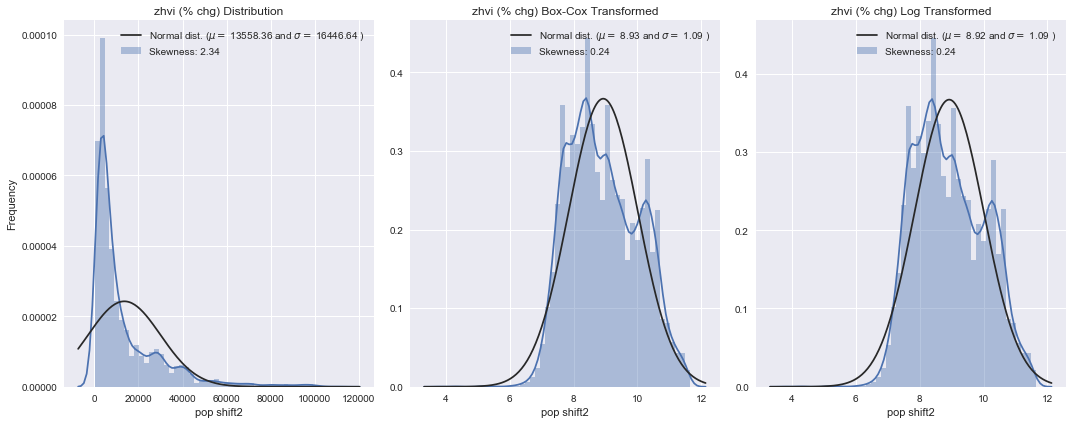

pop dens shift2


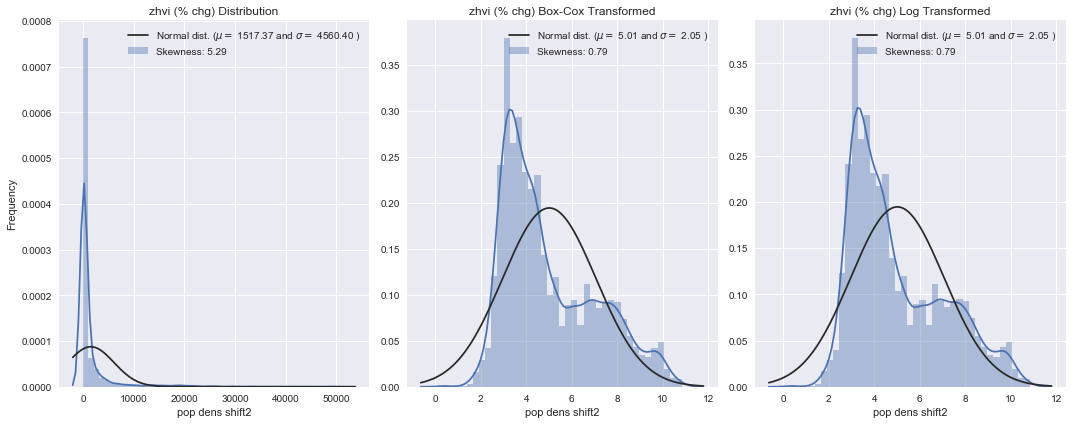

num R shift3


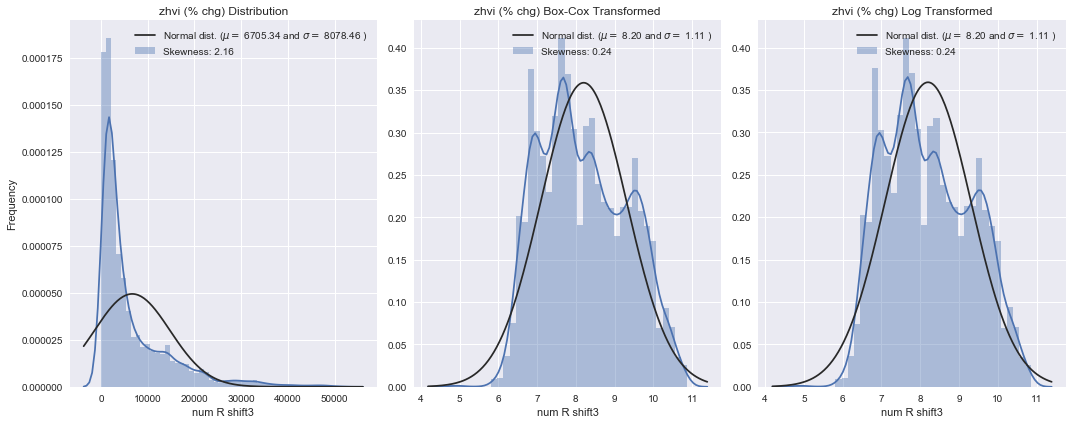

avg AGI shift3


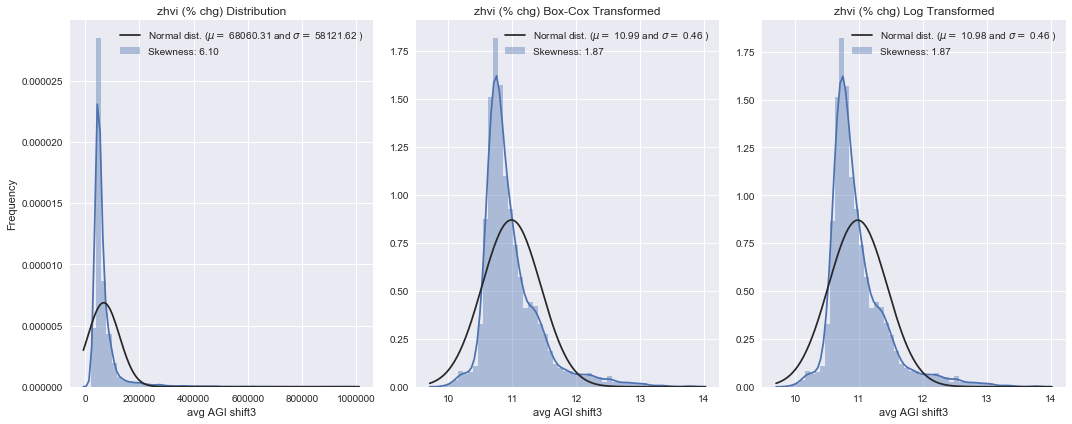

avg SW shift3


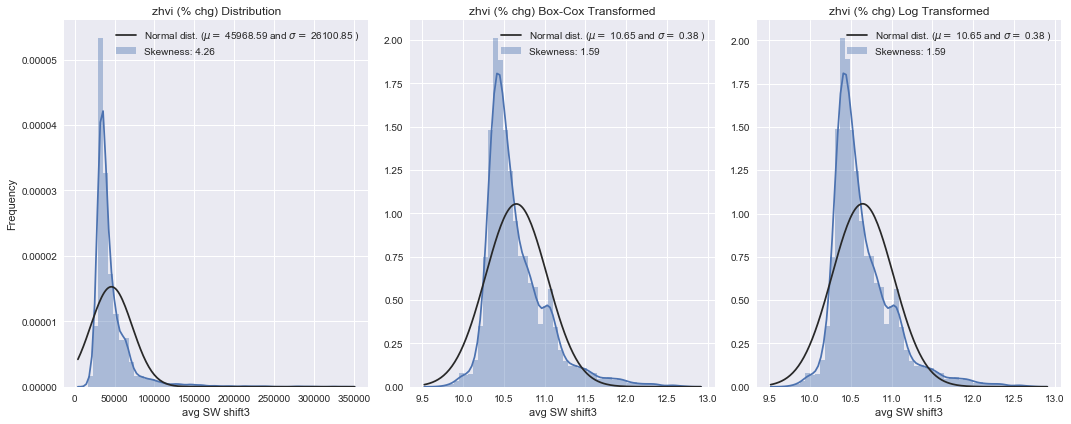

avg OI shift3


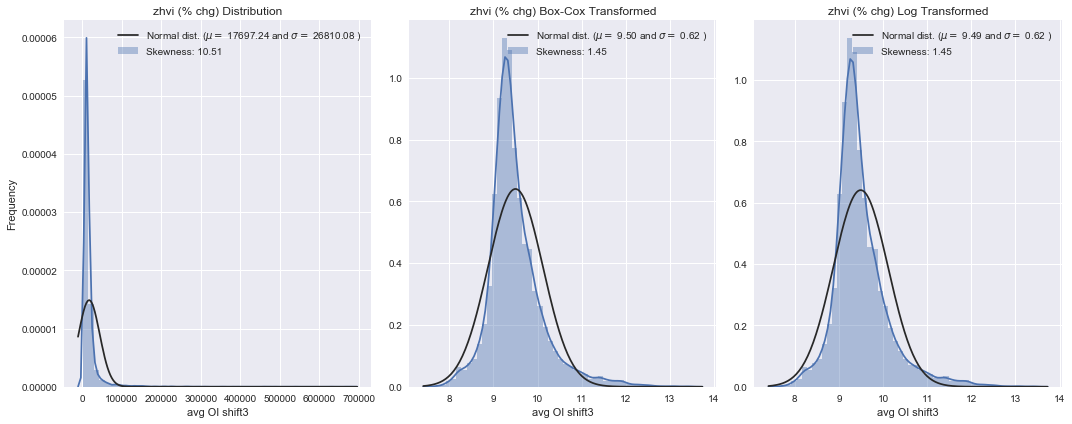

In [361]:
#Feature: some annual columns, trying to correct for skewness
for col in ['pop shift2', 'pop dens shift2', 'num R shift3', 'avg AGI shift3', 'avg SW shift3', 'avg OI shift3']:
    print(col)
    temp = annual_stacked[col].dropna()
    lam = 0.0001
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
    sns.distplot(temp, fit = norm, ax = ax1)
    sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2)
    sns.distplot(np.log1p(temp), fit = norm, ax = ax3)
    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(temp)
    (mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
    (mu3, sigma3) = norm.fit(np.log1p(temp))
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
                'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
    ax1.set_ylabel('Frequency')
    ax1.set_title('zhvi (% chg) Distribution')
    ax2.set_title('zhvi (% chg) Box-Cox Transformed')
    ax3.set_title('zhvi (% chg) Log Transformed')
    plt.tight_layout()
    plt.show()

num R z shift3


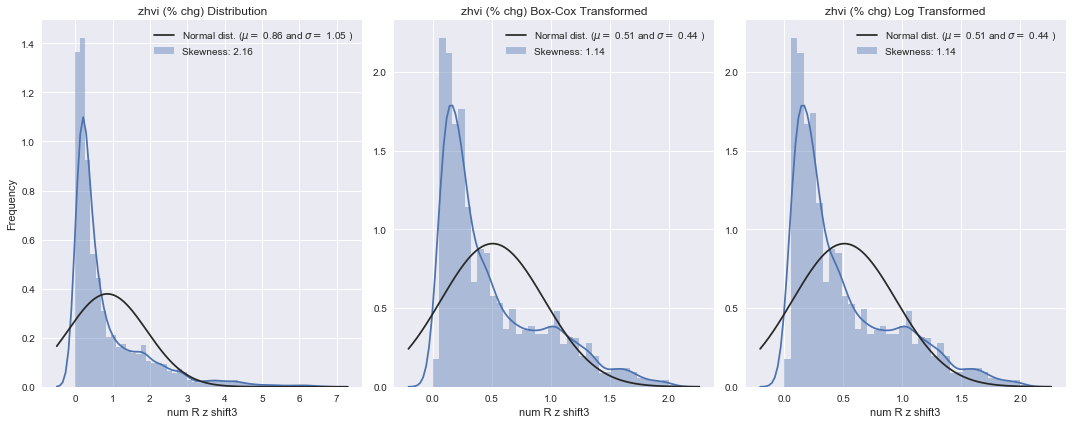

avg AGI z shift3


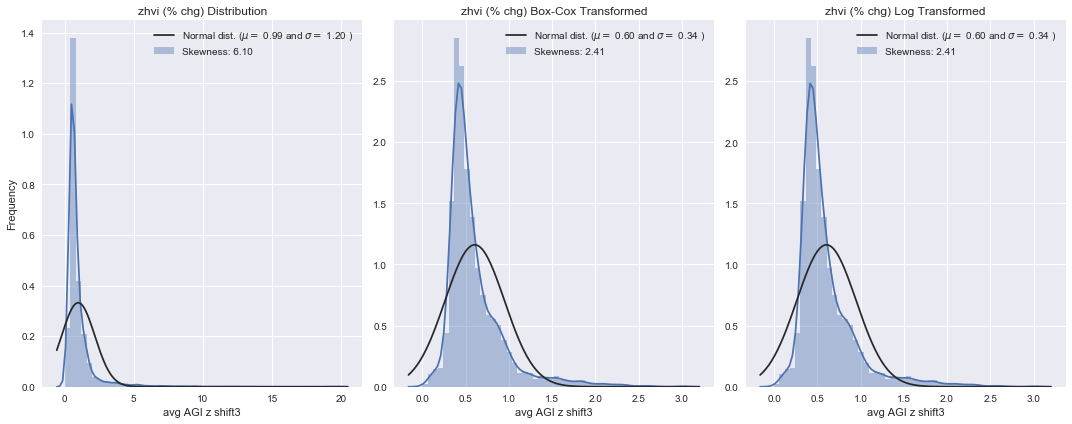

avg SW z shift3


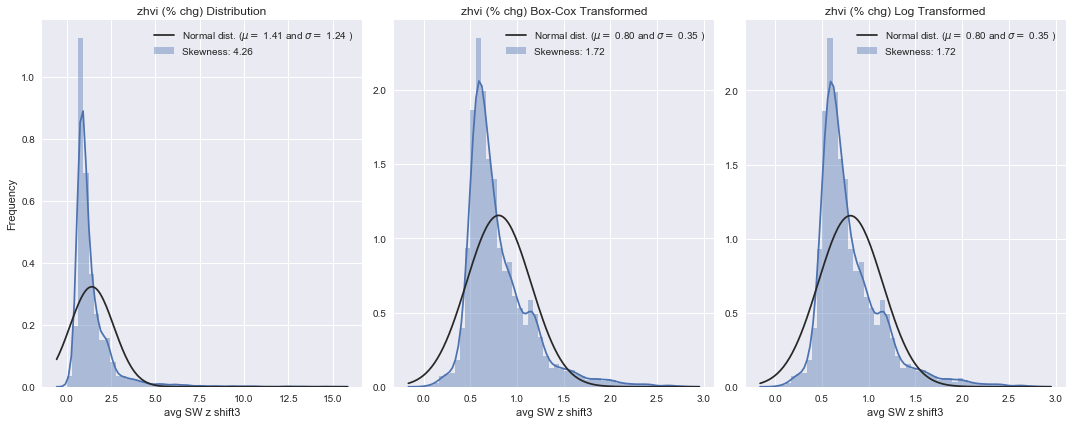

avg OI z shift3


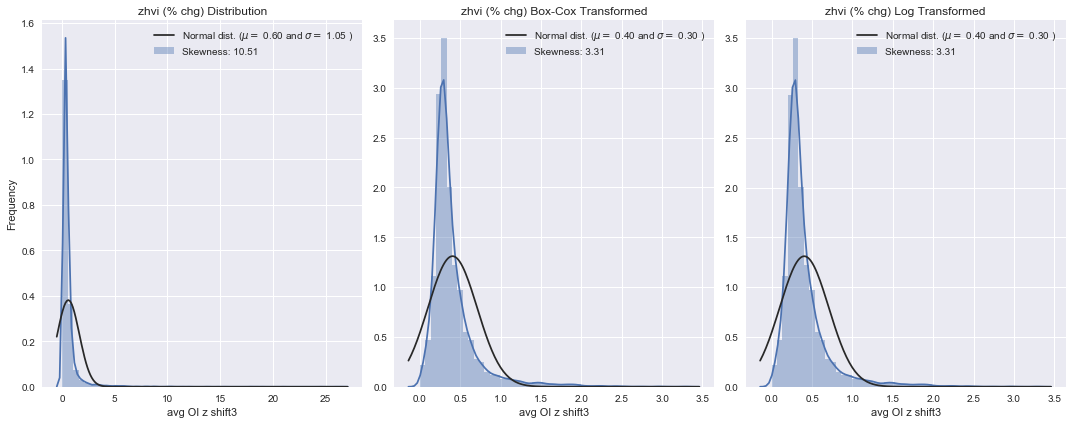

In [362]:
#Feature: some annual columns, trying to correct for skewness
for col in ['num R z shift3', 'avg AGI z shift3', 'avg SW z shift3', 'avg OI z shift3']:
    print(col)
    temp = annual_stacked[col].dropna()
    temp = temp - temp.min()
    lam = 0.0001
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15,6))
    sns.distplot(temp, fit = norm, ax = ax1)
    sns.distplot(boxcox1p(temp, lam), fit = norm, ax = ax2)
    sns.distplot(np.log1p(temp), fit = norm, ax = ax3)
    # Get the fitted parameters used by the function
    (mu1, sigma1) = norm.fit(temp)
    (mu2, sigma2) = norm.fit(boxcox1p(temp, lam))
    (mu3, sigma3) = norm.fit(np.log1p(temp))
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1),
                'Skewness: {:.2f}'.format(skew(temp))], loc = 'best')
    ax2.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2),
                'Skewness: {:.2f}'.format(skew(boxcox1p(temp, lam)))], loc = 'best')
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu3, sigma3),
                'Skewness: {:.2f}'.format(skew(np.log1p(temp)))], loc = 'best')
    ax1.set_ylabel('Frequency')
    ax1.set_title('zhvi (% chg) Distribution')
    ax2.set_title('zhvi (% chg) Box-Cox Transformed')
    ax3.set_title('zhvi (% chg) Log Transformed')
    plt.tight_layout()
    plt.show()

feature names: pop


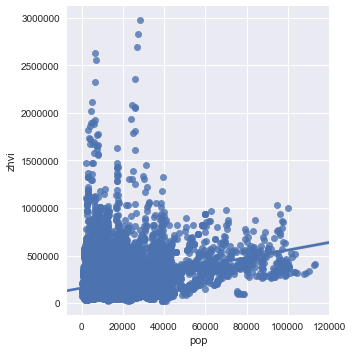

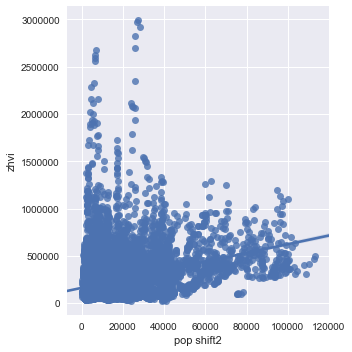

pop v. zhvi:  (0.3181984289166549, 1.7984493197113852e-296)
pop shift2 v. zhvi:  (0.3352022341135479, 0.0)


feature names: pop dens


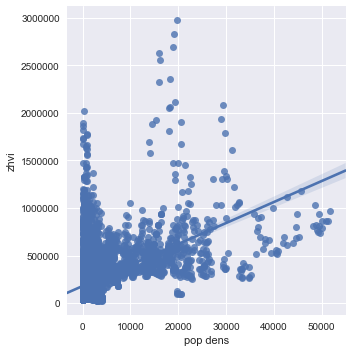

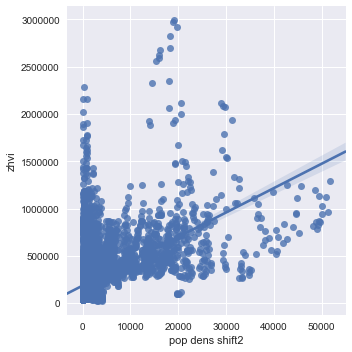

pop dens v. zhvi:  (0.4890591035408136, 0.0)
pop dens shift2 v. zhvi:  (0.5196491600233929, 0.0)


feature names: num R z


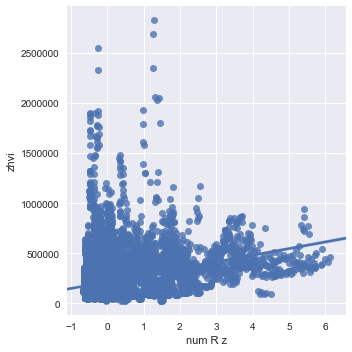

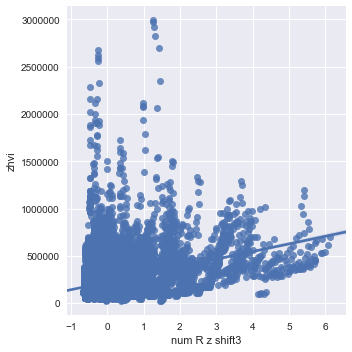

num R z v. zhvi:  (0.3332993118945623, 9.590597996389982e-273)
num R z shift3 v. zhvi:  (0.3584952816545137, 5.226014e-318)


feature names: avg AGI z


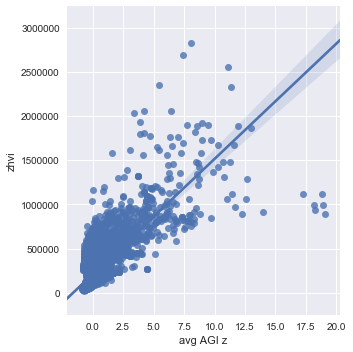

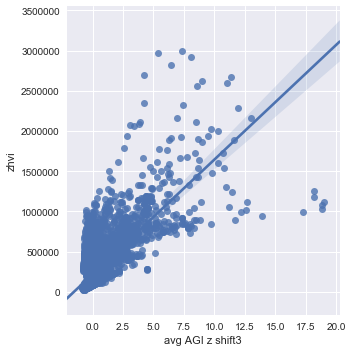

avg AGI z v. zhvi:  (0.7459007637640614, 0.0)
avg AGI z shift3 v. zhvi:  (0.7207689931194635, 0.0)


feature names: avg SW z


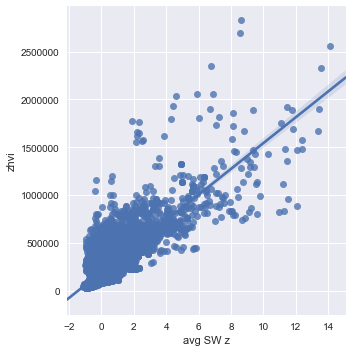

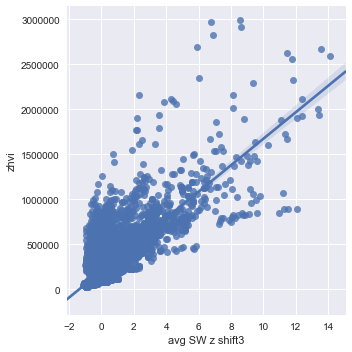

avg SW z v. zhvi:  (0.7932538494821707, 0.0)
avg SW z shift3 v. zhvi:  (0.7662870266020807, 0.0)


feature names: avg OI z


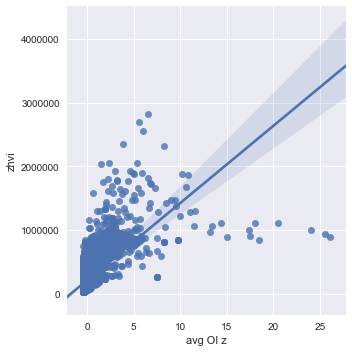

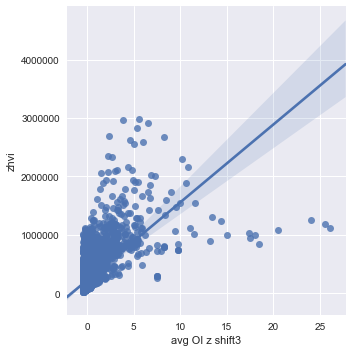

avg OI z v. zhvi:  (0.60291834230506, 0.0)
avg OI z shift3 v. zhvi:  (0.5865373584323376, 0.0)




In [369]:
for col in zip(['pop', 'pop dens', 'num R z', 'avg AGI z', 'avg SW z', 'avg OI z'],
               [' shift2', ' shift2', ' shift3', ' shift3', ' shift3', ' shift3']):
    print('feature names: {}'.format(col[0]))
    allzips1 = annual_stacked[[col[0], 'zhvi', 'zip']].dropna()
    allzips2 = annual_stacked[[col[0] + col[1], 'zhvi', 'zip']].dropna()
    #fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15,6))
    sns.lmplot(data = allzips1, x = col[0], y = 'zhvi')
    sns.lmplot(data = allzips2, x = col[0] + col[1], y = 'zhvi')
    plt.tight_layout()
    plt.show()

    print('{} v. zhvi: '.format(col[0]), pearsonr(allzips1['zhvi'], allzips1[col[0]]))
    print('{} v. zhvi: '.format(col[0] + col[1]), pearsonr(allzips2['zhvi'], allzips2[col[0] + col[1]]))
    print('\n')

feature names: pop


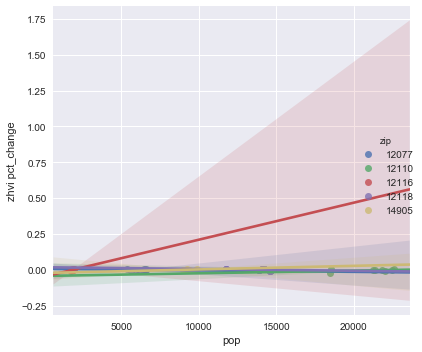

14905
pop v. zhvi pct_change:  (0.25838205301072453, 0.5366641880469851)
12077
pop v. zhvi pct_change:  (-0.09775868215496039, 0.8178669431072616)
12118
pop v. zhvi pct_change:  (-0.34121077011271955, 0.05598046356699648)
12116
pop v. zhvi pct_change:  (0.5269189213060049, 0.17966480688874872)
12110
pop v. zhvi pct_change:  (0.4166594387995043, 0.3044722060582653)


feature names: pop dens


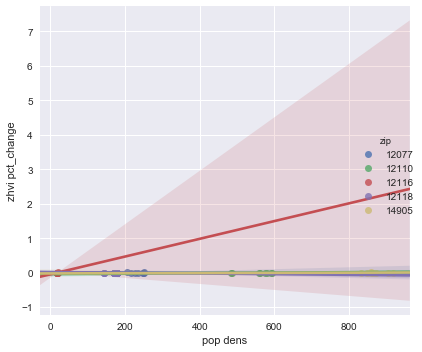

14905
pop dens v. zhvi pct_change:  (0.2583820530107241, 0.5366641880469859)
12077
pop dens v. zhvi pct_change:  (-0.09775868215496077, 0.8178669431072606)
12118
pop dens v. zhvi pct_change:  (-0.34121077011271894, 0.05598046356699696)
12116
pop dens v. zhvi pct_change:  (0.5269189213060049, 0.17966480688874872)
12110
pop dens v. zhvi pct_change:  (0.4166594387995042, 0.30447220605826547)


feature names: num R


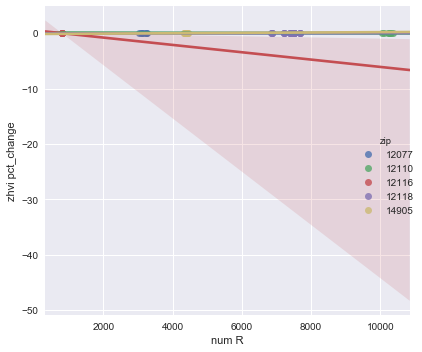

14905
num R v. zhvi pct_change:  (0.5771627517366944, 0.17486113855584157)
12077
num R v. zhvi pct_change:  (0.05921171122847949, 0.8996551988149476)
12118
num R v. zhvi pct_change:  (0.5916312785037995, 0.001839006235235097)
12116
num R v. zhvi pct_change:  (-0.6354472276373747, 0.1251147386207028)
12110
num R v. zhvi pct_change:  (-0.3553408375417535, 0.43410708443891877)


feature names: avg AGI


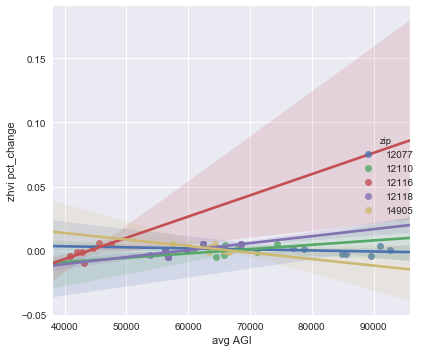

14905
avg AGI v. zhvi pct_change:  (-0.5944368328372072, 0.15925052271562068)
12077
avg AGI v. zhvi pct_change:  (-0.16203101365677994, 0.728524225171528)
12118
avg AGI v. zhvi pct_change:  (0.7313839688051621, 3.2711430453037885e-05)
12116
avg AGI v. zhvi pct_change:  (0.7002351114442767, 0.07977138963940274)
12110
avg AGI v. zhvi pct_change:  (0.4024691696249422, 0.3707124782671243)




In [330]:
for col in zip(['pop', 'pop dens', 'num R z', 'avg AGI z', 'avg SW z', 'avg OI z'],
               [' shift2', ' shift2', ' shift3', ' shift3', ' shift3', ' shift3']):
    print('feature names: {}'.format(col[0]))
    allzips1 = annual_stacked[[col[0], 'zhvi pct_change', 'zip']].dropna()
    allzips2 = annual_stacked[[col[0] + col[1], 'zhvi', 'zip']].dropna()
    #fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15,6))
    sns.lmplot(data = allzips1, x = col[0], y = 'zhvi')
    sns.lmplot(data = allzips2, x = col[0] + col[1], y = 'zhvi')
    plt.tight_layout()
    plt.show()

    print('{} v. zhvi: '.format(col[0]), pearsonr(allzips1['zhvi'], allzips1[col[0]]))
    print('{} v. zhvi: '.format(col[0] + col[1]), pearsonr(allzips2['zhvi'], allzips2[col[0] + col[1]]))
    print('\n')

### PCA?

In [ ]:
for zipcode in example_zips:
    print(zipcode)
    heatmap2 = temp3_df[temp3_df.zip == zipcode][['zhvi pct_change', 'N_MA pct_change', 'N_MA pct_change 1', 
                                                  'N_MA pct_change 6', 'N_MA pct_change 12', 'N_MA pct_change 24']].corr()
    sns.heatmap(heatmap2, annot = True, cmap = 'RdBu_r')
    plt.yticks(rotation = 0) 
    plt.title('zhvi pct_change vs. NASDAQ pct_change' + zipcode)
    plt.tight_layout()
    plt.show()